**stage2_DANN**. This notebook is the initial attempt to train a DANN with UMAFall_waist as source data and UPFall_waist as target data.

**Edit**<br/>

**TODO**<br/>

# Import packages and get authenticated

In [1]:
from google.colab import drive
drive.mount('drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


In [0]:
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc( 'savefig', facecolor = 'white' )

import pandas as pd
pd.set_option('display.max_columns', 500)
from tqdm import tqdm_notebook as tqdm
import os
import sys
from IPython.display import display

import time
import datetime
from datetime import datetime
import json

from sklearn.decomposition import PCA

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [0]:
def data_saver(data, name, outputdir):
  """ usage: data_saver(df_merged_interp_alldicts, 'data', outputdir)"""
  outputdir_data = os.path.join(outputdir, name+'.npz')
  print('outputdir for {}:'.format(name), outputdir_data)
  np.savez(outputdir_data, data=data, allow_pickle=True)
  loaded_data = np.load(outputdir_data, allow_pickle=True)['data']
#     loaded_data = np.load(outputdir_data, allow_pickle=True)['data']
  print('Are {} save and loadded correctly? '.format(name), np.array_equal(loaded_data, data))
  print('')
    
def data_loader(name, inputdir):
  """ usage: data = data_loader('data', outputdir)"""
  inputdir_data = os.path.join(inputdir, name+'.npz')
  data = np.load(inputdir_data, allow_pickle=True)['data']
  return data

### model definitions

In [0]:
# Convolutional neural network (two convolutional layers)
class ConvNet(nn.Module):
  def __init__(self, num_classes=10, input_dim=50):
      super(ConvNet, self).__init__()
      self.layer1 = nn.Sequential(
          nn.Conv1d(3, 16, kernel_size=3, stride=1, padding=2),
          nn.BatchNorm1d(16),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=2, stride=2))
      self.layer2 = nn.Sequential(
          nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=2),
          nn.BatchNorm1d(32),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=2, stride=2))
      self.layer3 = nn.Sequential(
          nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=2),
          nn.BatchNorm1d(64),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=2, stride=2))
      
      cnn_layer1_dim = (input_dim+2*2-1*(3-1)-1)+1
      pool_layer1_dim = (cnn_layer1_dim-1*(2-1)-1)/2+1

      cnn_layer2_dim = (pool_layer1_dim+2*2-1*(3-1)-1)+1
      pool_layer2_dim = (cnn_layer2_dim-1*(2-1)-1)/2+1

      cnn_layer3_dim = (pool_layer2_dim+2*2-1*(3-1)-1)+1
      pool_layer3_dim = (cnn_layer3_dim-1*(2-1)-1)/2+1

      # print('cnn_layer1_dim:', cnn_layer1_dim)
      # print('pool_layer1_dim:', pool_layer1_dim)
      # print('cnn_layer2_dim:', cnn_layer2_dim)
      # print('pool_layer2_dim:', pool_layer2_dim)
      # print('cnn_layer3_dim:', cnn_layer3_dim)
      # print('pool_layer3_dim:', pool_layer3_dim)
      # fc_dim = int(((((input_dim)+2*2-1)/2+2*2-1)/2+2*2-1)/2*64)
      self.fc = nn.Linear(int(pool_layer3_dim)*64, num_classes)
      
  def forward(self, x):
    out1 = self.layer1(x.float())
    # print('out1 size:', out1.size())
    out2 = self.layer2(out1)
    # print('out2 size:', out2.size())
    out3 = self.layer3(out2)
    # print('out3 size:', out3.size())
    out3 = out3.reshape(out3.size(0), -1)
    # print('out3 size:', out3.size())
    out4 = self.fc(out3)
    # print('x, out1, out2, out 3, out4 size',  x.size(), out1.size(), out2.size(), out3.size(), out4.size())
    return out4

In [0]:
class GradReverse(torch.autograd.Function):
  """
  Extension of grad reverse layer
  """
  @staticmethod
  def forward(ctx, x, constant):
      ctx.constant = constant
      return x.view_as(x)

  @staticmethod
  def backward(ctx, grad_output):
      grad_output = grad_output.neg() * ctx.constant
      return grad_output, None

  def grad_reverse(x, constant):
      return GradReverse.apply(x, constant)

In [0]:
# Convolutional neural network (two convolutional layers)
class FeatureExtractor(nn.Module):
  def __init__(self, input_dim=50, channel_n=16):
      super(FeatureExtractor, self).__init__()
      self.layer1 = nn.Sequential(
          nn.Conv1d(3, channel_n, kernel_size=3, stride=1, padding=2),
          nn.BatchNorm1d(channel_n),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=2, stride=2))
      self.layer2 = nn.Sequential(
          nn.Conv1d(channel_n, channel_n*2, kernel_size=3, stride=1, padding=2),
          nn.BatchNorm1d(channel_n*2),
          nn.ReLU(),
          nn.MaxPool1d(kernel_size=2, stride=2))
      # self.layer3 = nn.Sequential(
      #     nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=2),
      #     nn.BatchNorm1d(64),
      #     nn.ReLU(),
      #     nn.MaxPool1d(kernel_size=2, stride=2))
      
      cnn_layer1_dim = (input_dim+2*2-1*(3-1)-1)+1
      pool_layer1_dim = (cnn_layer1_dim-1*(2-1)-1)/2+1

      cnn_layer2_dim = (pool_layer1_dim+2*2-1*(3-1)-1)+1
      pool_layer2_dim = (cnn_layer2_dim-1*(2-1)-1)/2+1

      # cnn_layer3_dim = (pool_layer2_dim+2*2-1*(3-1)-1)+1
      # pool_layer3_dim = (cnn_layer3_dim-1*(2-1)-1)/2+1

      # print('cnn_layer1_dim:', cnn_layer1_dim)
      # print('pool_layer1_dim:', pool_layer1_dim)
      # print('cnn_layer2_dim:', cnn_layer2_dim)
      # print('pool_layer2_dim:', pool_layer2_dim)
      # print('cnn_layer3_dim:', cnn_layer3_dim)
      # print('pool_layer3_dim:', pool_layer3_dim)
      # fc_dim = int(((((input_dim)+2*2-1)/2+2*2-1)/2+2*2-1)/2*64)
      # self.fc = nn.Linear(int(pool_layer2_dim)*32, num_classes)
      
  def forward(self, x):
    out1 = self.layer1(x.float())
    # print('out1 size:', out1.size())
    out2 = self.layer2(out1)
    # print('out2 size:', out2.size())
    # out3 = self.layer3(out2)
    # print('out3 size:', out3.size())
    # out3 = out3.reshape(out3.size(0), -1)
    out2 = out2.reshape(out2.size(0), -1)
    # print('out3 size:', out3.size())
    # out3 = self.fc(out2)
    # print('x, out1, out2, out 3, out4 size',  x.size(), out1.size(), out2.size(), out3.size(), out4.size())
    return out2

# fall classifier neural network (fc layers)
class ClassClassifier(nn.Module):
  def __init__(self, num_classes=10, input_dim=50):
      super(ClassClassifier, self).__init__()
      self.fc = nn.Linear(input_dim, num_classes)
      
  def forward(self, x):
    # out1 = F.relu(self.fc(x))
    out1 = self.fc(x.float())
    return out1

# domain classifier neural network (fc layers)
class DomainClassifier(nn.Module):
  def __init__(self, num_classes=10, input_dim=50):
      super(DomainClassifier, self).__init__()
      self.fc = nn.Linear(input_dim, num_classes)
      
  def forward(self, x, constant):
    out1 = GradReverse.grad_reverse(x.float(), constant)
    # out2 = F.relu(self.fc(out1))
    out2 = self.fc(out1)
    return out2

class CascadedModel(nn.Module):
  def __init__(self, modelA, modelB):
    super(CascadedModel, self).__init__()
    self.modelA = modelA
    self.modelB = modelB
      
  def forward(self, x):
    out1 = self.modelA(x.float())
    out2 = self.modelB(out1)
    return out2

In [0]:
class DannModel(nn.Module):
  def __init__(self, device, class_N=2, domain_N=2, channel_n=16, input_dim=10):
    super(DannModel, self).__init__()
    self.feature_extractor = FeatureExtractor(input_dim=input_dim, channel_n=channel_n).to(device).float()
    cnn_layer1_dim = (input_dim+2*2-1*(3-1)-1)+1
    pool_layer1_dim = (cnn_layer1_dim-1*(2-1)-1)/2+1

    cnn_layer2_dim = (pool_layer1_dim+2*2-1*(3-1)-1)+1
    pool_layer2_dim = (cnn_layer2_dim-1*(2-1)-1)/2+1

    feature_out_dim = int(pool_layer2_dim*channel_n*2)

    self.class_classfier = ClassClassifier(num_classes=class_N, input_dim=feature_out_dim).to(device).float()
    self.domain_classifier = DomainClassifier(num_classes=domain_N, input_dim=feature_out_dim).to(device).float()
      
  def forward(self, x):
    feature_out = self.feature_extractor(x)
    class_output = self.class_classfier(feature_out)
    domain_output = self.domain_classifier(feature_out, 1)
    # return feature_out
    return feature_out, class_output, domain_output

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
dann = DannModel(device, class_N=2, domain_N=2, input_dim=66).to(device).float()


In [0]:
class BaselineModel(nn.Module):
  def __init__(self, device, class_N=2, channel_n=16, input_dim=10):
    super(BaselineModel, self).__init__()
    self.feature_extractor = FeatureExtractor(input_dim=input_dim, channel_n=channel_n).to(device).float()
    cnn_layer1_dim = (input_dim+2*2-1*(3-1)-1)+1
    pool_layer1_dim = (cnn_layer1_dim-1*(2-1)-1)/2+1

    cnn_layer2_dim = (pool_layer1_dim+2*2-1*(3-1)-1)+1
    pool_layer2_dim = (cnn_layer2_dim-1*(2-1)-1)/2+1

    feature_out_dim = int(pool_layer2_dim*channel_n*2)

    self.class_classfier = ClassClassifier(num_classes=class_N, input_dim=feature_out_dim).to(device).float()
    # self.domain_classifier = DomainClassifier(num_classes=domain_N, input_dim=feature_out_dim).to(device).float()
      
  def forward(self, x):
    feature_out = self.feature_extractor(x)
    # print('feature_out size', feature_out.size())
    class_out = self.class_classfier(feature_out)
    # domain_output = self.domain_classifier(feature_out, 1)
    # return feature_out
    return feature_out, class_out

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = BaselineModel(device, class_N=2, channel_n=10, input_dim=66).to(device).float()


### model unit testing

In [9]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_1 = FeatureExtractor(input_dim=66).to(device).float()


test_input = torch.randn((8, 3, 66), dtype=torch.double)

feature_out = model_1(test_input)
print('show model_1 output size:', feature_out.size())

feature_out_dim =  feature_out.size()[1]
model_2 = ClassClassifier(num_classes=2, input_dim=feature_out_dim).to(device).float()
model_3 = DomainClassifier(num_classes=2, input_dim=feature_out_dim).to(device).float()

model_2_out = model_2(feature_out)
print('show model_2 output size:', model_2_out.size())

model_3_out = model_3(feature_out, 1)
print('show model_3 output size:', model_3_out.size())

model_4 = CascadedModel(model_1, model_2)
# model_4 = nn.Sequential(model_1, model_2)

print('model_4 output size', model_4(test_input).size())

dann = DannModel(device, class_N=2, domain_N=2, channel_n=5, input_dim=66).to(device).float()
feature_out, class_output, domain_output = dann(test_input)
print('dann output size', feature_out.size(), class_output.size(), domain_output.size())



show model_1 output size: torch.Size([8, 576])
show model_2 output size: torch.Size([8, 2])
show model_3 output size: torch.Size([8, 2])
model_4 output size torch.Size([8, 2])
dann output size torch.Size([8, 180]) torch.Size([8, 2]) torch.Size([8, 2])


# Exporting function for model performance, notebook parameters, and model

## export model performance

In [0]:
def export_perofmance(df_performance, CV_n, outputdir):
  df_performance.loc['mean'] = df_performance.iloc[0:CV_n-1].mean()
  df_performance.loc['std'] = df_performance.iloc[0:CV_n-1].std()
  print('show df_performance')
  display(df_performance)
  df_performance.to_csv(outputdir+'df_performance.csv')

## export model using torch.save and validate saved model

In [0]:
# def export_model(model, loaded_model, classes_n, input_dim, feature_out_dim, device, outputdir):
def export_model(model, loaded_model, outputdir):

  # Save
  torch.save(model.state_dict(), outputdir)
  # Load
  # loaded_model = ConvNet(num_classes=classes_n, input_dim=input_dim).to(device).float()
  # feature_extractor = FeatureExtractor(input_dim=input_dim).to(device).float()
  # class_classifier = ClassClassifier(num_classes=classes_n, input_dim=feature_out_dim).to(device).float()
  # domain_classifier = DomainClassifier(num_classes=2, input_dim=feature_out_dim).to(device).float()
  # loaded_model = CascadedModel(feature_extractor, class_classifier)

  loaded_model.load_state_dict(torch.load(outputdir))

  save_error = 0
  for p1, p2 in zip(model.parameters(), loaded_model.parameters()):
    if p1.data.ne(p2.data).sum() > 0:
      print('model not successfully saved')
      save_error = 1
      break

  if save_error == 0:
    print('model saved successfully')

## defining dataloader

In [0]:
class FallDataset(Dataset):
  def __init__(self, data, labels):
      self.data = torch.FloatTensor(data)
      self.labels = torch.FloatTensor(labels)
      # self.data = torch.LongTensor(data)
      # self.labels = torch.LongTensor(labels)

  def __getitem__(self, index):
      x = self.data[index,:,:]
      y = self.labels[index]
      return x, y

  def __len__(self):
      return len(self.data)

In [0]:
def get_UMAFall_loader(inputdir, i_CV, batch_size, learning_rate):
  print('Working on get_UMAFall_loader...')
  train_inputdir = inputdir+'/CV{}/train'.format(i_CV)
  val_inputdir = inputdir+'/CV{}/val'.format(i_CV)

  train_data = data_loader('data', train_inputdir).transpose(2,1,0)[:,:,0:66]
  val_data = data_loader('data', val_inputdir).transpose(2,1,0)[:,:,0:66]
  # train_data = data_loader('data', train_inputdir).transpose(2,1,0)
  # val_data = data_loader('data', val_inputdir).transpose(2,1,0)

  train_labels = data_loader('labels', train_inputdir)
  val_labels = data_loader('labels', val_inputdir)

  train_i_sub = data_loader('i_sub', train_inputdir)
  val_i_sub = data_loader('i_sub', val_inputdir)

  print('train_data shape:', train_data.shape)
  print('val_data shape:', val_data.shape)

  train_size = train_labels.shape[0]
  val_size = val_labels.shape[0]
  input_dim = train_data.shape[2]

  # convert labels from multi-class activities to binary (fall/ADL)
  train_labels_binary = ((train_labels==10)|(train_labels==11)|(train_labels==12)).astype(int)
  val_labels_binary = ((val_labels==10)|(val_labels==11)|(val_labels==12)).astype(int)

  train_dataset = FallDataset(train_data, train_labels_binary)
  val_dataset = FallDataset(val_data, val_labels_binary)
  # data loader
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=batch_size, 
                                            shuffle=True)
  val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                            batch_size=batch_size, 
                                            shuffle=False)

  return train_loader, val_loader


In [0]:
def get_UPFall_loader(inputdir, i_CV, batch_size, learning_rate):
  print('Working on get_UPFall_loader...')
  train_inputdir = inputdir+'/CV{}/train'.format(i_CV)
  val_inputdir = inputdir+'/CV{}/val'.format(i_CV)

  # train_data = data_loader('data', train_inputdir).transpose(2,1,0)
  # val_data = data_loader('data', val_inputdir).transpose(2,1,0)
  train_data = data_loader('data', train_inputdir).transpose(2,1,0)[:,:,0:66]
  val_data = data_loader('data', val_inputdir).transpose(2,1,0)[:,:,0:66]

  train_labels = data_loader('labels', train_inputdir)
  val_labels = data_loader('labels', val_inputdir)

  train_i_sub = data_loader('i_sub', train_inputdir)
  val_i_sub = data_loader('i_sub', val_inputdir)

  print('train_data shape:', train_data.shape)
  print('val_data shape:', val_data.shape)

  train_size = train_labels.shape[0]
  val_size = val_labels.shape[0]
  input_dim = train_data.shape[2]

  # convert labels from multi-class activities to binary (fall/ADL)
  train_labels_binary = ((train_labels==1)|(train_labels==2)|(train_labels==3)|(train_labels==4)|(train_labels==5)).astype(int)
  val_labels_binary = ((val_labels==1)|(val_labels==2)|(val_labels==3)|(val_labels==4)|(val_labels==5)).astype(int)

  train_dataset = FallDataset(train_data, train_labels_binary)
  val_dataset = FallDataset(val_data, val_labels_binary)
  # data loader
  train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                            batch_size=batch_size, 
                                            shuffle=True)
  val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                            batch_size=batch_size, 
                                            shuffle=False)

  return train_loader, val_loader


## train and validate an epoch

In [0]:
def train_epoch(train_loader, train_size, device, model, criterion, optimizer, epoch):
  total_train_loss = 0
  train_TPTF = 0
  for i, (data, labels) in enumerate(train_loader):

    data = data.to(device)
    labels = labels.to(device).long()

    # Forward pass
    feature_out, class_out = model(data)
    train_loss = criterion(class_out, labels)
    total_train_loss += train_loss.data.numpy()
    
    out_sigmoid = torch.sigmoid(class_out).data.numpy()
    train_pred = np.argmax(out_sigmoid, 1)
    train_TPTF += (train_pred==labels.data.numpy()).sum()

    # Backward and optimize
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

  train_loss = total_train_loss/train_size
  train_acc = train_TPTF/train_size

  return train_loss, train_acc

def val_epoch(val_loader, val_size, device, model, criterion, optimizer, epoch):
  total_val_loss = 0
  val_TPTF = 0
  for i, (data, labels) in enumerate(val_loader):
    data = data.to(device)
    labels = labels.to(device).long()
    
    #Forward pass
    feature_out, class_out = model(data)
    # print(data.size(), val_outputs.size())

    val_loss = criterion(class_out, labels)
    total_val_loss += val_loss.data.numpy()

    out_sigmoid = torch.sigmoid(class_out).data.numpy()
    val_pred = np.argmax(out_sigmoid, 1)
    val_TPTF += (val_pred==labels.data.numpy()).sum()

  val_loss = total_val_loss/val_size
  val_acc = val_TPTF/val_size

  return val_loss, val_acc

### to be **deprecated**

In [0]:
# def train_epoch_dann(src_loader, tgt_loader, src_train_size, tgt_train_size, device, 
#                      feature_extractor, class_classifier, domain_classifier,
#                      class_criterion, domain_criterion, optimizer, epoch):
#   total_train_loss = 0
#   total_src_class_loss = 0
#   total_tgt_class_loss = 0
#   total_src_domain_loss = 0
#   total_tgt_domain_loss = 0

#   src_class_TPTN = 0
#   tgt_class_TPTN = 0
#   domain_TPTN = 0
#    # note that this is different from src_train_size as src_loader and 
#    # tgt_loader have different sample size
#   src_train_count = 0
#   tgt_train_count = 0
#   train_size = src_train_size + tgt_train_size

#   # print('show loader size:', len(src_loader), len(tgt_loader))
#   for i, (sdata, tdata) in enumerate(zip(src_loader, tgt_loader)):
#   # for i, sdata in enumerate(src_loader):
#     src_data, src_labels = sdata
#     tgt_data, tgt_labels = tdata
#     # print('show data and label size:', src_data.size()[0])
#     src_train_count += src_data.size()[0]
#     tgt_train_count += tgt_data.size()[0]

#     src_data = src_data.to(device)
#     src_labels = src_labels.to(device).long()
#     tgt_data = tgt_data.to(device)
#     tgt_labels = tgt_labels.to(device).long()

#     # prepare domain labels
#     src_domain_labels = torch.zeros(src_data.size()[0]).to(device).long()
#     tgt_domain_labels = torch.ones(tgt_data.size()[0]).to(device).long()
#     # print('show domain labels:', src_domain_labels, tgt_domain_labels)

#     ## CLASS CLASSIFICATION
#     # compute the output of source domain and target domain
#     src_feature = feature_extractor(src_data)
#     tgt_feature = feature_extractor(tgt_data)

#     # compute the class loss of src_feature
#     src_class_out = class_classifier(src_feature)
#     src_class_loss = class_criterion(src_class_out, src_labels)
#     tgt_class_out = class_classifier(tgt_feature)
#     tgt_class_loss = class_criterion(tgt_class_out, tgt_labels)

#     # make prediction based on logits output class_out
#     out_sigmoid = torch.sigmoid(src_class_out).data.numpy()
#     src_class_pred = np.argmax(out_sigmoid, 1)
#     out_sigmoid = torch.sigmoid(tgt_class_out).data.numpy()
#     tgt_class_pred = np.argmax(out_sigmoid, 1)

#     # ## DOMAIN CLASSIFICATION
#     # # compute the domain loss of src_feature and target_feature
#     src_domain_out = domain_classifier(src_feature, 1)
#     tgt_domain_out = domain_classifier(tgt_feature, 1)

#     # make prediction based on logits output domain_out
#     out_sigmoid = torch.sigmoid(src_domain_out).data.numpy()
#     src_domain_pred = np.argmax(out_sigmoid, 1)
#     out_sigmoid = torch.sigmoid(tgt_domain_out).data.numpy()
#     tgt_domain_pred = np.argmax(out_sigmoid, 1)

#     src_domain_loss = domain_criterion(src_domain_out, src_domain_labels)
#     tgt_domain_loss = domain_criterion(tgt_domain_out, tgt_domain_labels)
#     domain_loss = src_domain_loss + tgt_domain_loss

#     theta = 1
#     train_loss = src_class_loss + theta * domain_loss
#     # train_loss = src_class_loss
#     # Backward and optimize
#     optimizer.zero_grad()
#     # train_loss.backward()
#     train_loss.backward()
#     optimizer.step()

#     # total_train_loss += train_loss.data.numpy()
#     total_src_class_loss += src_class_loss.data.numpy()
#     total_tgt_class_loss += tgt_class_loss.data.numpy()
#     total_src_domain_loss += src_domain_loss.data.numpy()
#     total_tgt_domain_loss += tgt_domain_loss.data.numpy()

#     src_class_TPTN += (src_class_pred==src_labels.data.numpy()).sum()
#     tgt_class_TPTN += (tgt_class_pred==tgt_labels.data.numpy()).sum()
#     domain_TPTN += (src_domain_pred==src_domain_labels.data.numpy()).sum()
#     domain_TPTN += (tgt_domain_pred==tgt_domain_labels.data.numpy()).sum()
#     # print(class_pred)
#     # print(train_loss)

#   # print('total TPTF:', train_TPTF)
#   # print('last i:', i)
#   # sys.exit()
#   train_count = src_train_count + tgt_train_count
#   # train_loss_avg = total_train_loss/train_count
#   src_class_loss_avg = total_src_class_loss/src_train_count
#   tgt_class_loss_avg = total_tgt_class_loss/tgt_train_count

#   src_domain_loss_avg = total_src_domain_loss/src_train_count
#   tgt_domain_loss_avg = total_tgt_domain_loss/tgt_train_count
#   train_loss_avg = src_class_loss_avg + theta * (src_domain_loss_avg + tgt_domain_loss_avg)

#   src_class_acc = src_class_TPTN/src_train_count
#   tgt_class_acc = tgt_class_TPTN/tgt_train_count
#   domain_acc = domain_TPTN/train_count

#   return train_loss_avg, src_class_loss_avg, tgt_class_loss_avg, src_domain_loss_avg, tgt_domain_loss_avg, src_class_acc, tgt_class_acc, domain_acc

In [0]:
# def val_epoch_dann(src_loader, tgt_loader, src_val_size, tgt_val_size, device, 
#                      feature_extractor, class_classifier, domain_classifier,
#                      class_criterion, domain_criterion, epoch):
#   total_val_loss = 0
#   total_src_class_loss = 0
#   total_tgt_class_loss = 0
#   total_src_domain_loss = 0
#   total_tgt_domain_loss = 0

#   src_class_TPTN = 0
#   tgt_class_TPTN = 0
#   domain_TPTN = 0
#    # note that this is different from src_val_size as src_loader and 
#    # tgt_loader have different sample size
#   src_val_count = 0
#   tgt_val_count = 0
#   val_size = src_val_size + tgt_val_size

#   # print('show loader size:', len(src_loader), len(tgt_loader))
#   for i, (sdata, tdata) in enumerate(zip(src_loader, tgt_loader)):
#   # for i, sdata in enumerate(src_loader):
#     src_data, src_labels = sdata
#     tgt_data, tgt_labels = tdata
#     # print('show data and label size:', src_data.size()[0])
#     src_val_count += src_data.size()[0]
#     tgt_val_count += tgt_data.size()[0]

#     src_data = src_data.to(device)
#     src_labels = src_labels.to(device).long()
#     tgt_data = tgt_data.to(device)
#     tgt_labels = tgt_labels.to(device).long()

#     # prepare domain labels
#     src_domain_labels = torch.zeros(src_data.size()[0]).to(device).long()
#     tgt_domain_labels = torch.ones(tgt_data.size()[0]).to(device).long()

#     ## CLASS CLASSIFICATION
#     # compute the output of source domain and target domain
#     src_feature = feature_extractor(src_data)
#     tgt_feature = feature_extractor(tgt_data)

#     # compute the class loss of src_feature
#     src_class_out = class_classifier(src_feature)
#     tgt_class_out = class_classifier(tgt_feature)

#     # make prediction based on logits output class_out
#     out_sigmoid = torch.sigmoid(src_class_out).data.numpy()
#     src_class_pred = np.argmax(out_sigmoid, 1)
#     out_sigmoid = torch.sigmoid(tgt_class_out).data.numpy()
#     tgt_class_pred = np.argmax(out_sigmoid, 1)


#     src_class_loss = class_criterion(src_class_out, src_labels)
#     tgt_class_loss = class_criterion(tgt_class_out, tgt_labels)



#     # ## DOMAIN CLASSIFICATION
#     # # compute the domain loss of src_feature and target_feature
#     src_domain_out = domain_classifier(src_feature, 1)
#     tgt_domain_out = domain_classifier(tgt_feature, 1)

#     # make prediction based on logits output domain_out
#     out_sigmoid = torch.sigmoid(src_domain_out).data.numpy()
#     src_domain_pred = np.argmax(out_sigmoid, 1)
#     out_sigmoid = torch.sigmoid(tgt_domain_out).data.numpy()
#     tgt_domain_pred = np.argmax(out_sigmoid, 1)

#     src_domain_loss = domain_criterion(src_domain_out, src_domain_labels)
#     tgt_domain_loss = domain_criterion(tgt_domain_out, tgt_domain_labels)
#     domain_loss = src_domain_loss + tgt_domain_loss

#     theta = 1
#     val_loss = src_class_loss + theta * domain_loss

#     # total_class_loss += src_class_loss.data.numpy()
#     total_src_class_loss += src_class_loss.data.numpy()
#     total_tgt_class_loss += tgt_class_loss.data.numpy()
#     total_src_domain_loss += src_domain_loss.data.numpy()
#     total_tgt_domain_loss += tgt_domain_loss.data.numpy()

#     src_class_TPTN += (src_class_pred==src_labels.data.numpy()).sum()
#     tgt_class_TPTN += (tgt_class_pred==tgt_labels.data.numpy()).sum()
#     domain_TPTN += (src_domain_pred==src_domain_labels.data.numpy()).sum()
#     domain_TPTN += (tgt_domain_pred==tgt_domain_labels.data.numpy()).sum()


#   val_count = src_val_count + tgt_val_count
#   src_class_loss_avg = total_src_class_loss/src_val_count
#   tgt_class_loss_avg = total_tgt_class_loss/tgt_val_count
#   src_domain_loss_avg = total_src_domain_loss/src_val_count
#   tgt_domain_loss_avg = total_tgt_domain_loss/tgt_val_count
#   val_loss_avg = src_class_loss_avg + theta * (src_domain_loss_avg + tgt_domain_loss_avg)

#   src_class_acc = src_class_TPTN/src_val_count
#   tgt_class_acc = tgt_class_TPTN/tgt_val_count
#   domain_acc = domain_TPTN/val_count

#   return val_loss_avg, src_class_loss_avg, tgt_class_loss_avg, src_domain_loss_avg, tgt_domain_loss_avg, src_class_acc, tgt_class_acc, domain_acc

### dann train and val code

In [0]:
def train_epoch_dann(src_loader, tgt_loader, src_train_size, tgt_train_size, device, 
                        dann,
                        class_criterion, domain_criterion, optimizer, epoch):
  total_train_loss = 0
  total_src_class_loss = 0
  total_tgt_class_loss = 0
  total_src_domain_loss = 0
  total_tgt_domain_loss = 0

  src_class_TPTN = 0
  tgt_class_TPTN = 0
  domain_TPTN = 0
   # note that this is different from src_train_size as src_loader and 
   # tgt_loader have different sample size
  src_train_count = 0
  tgt_train_count = 0
  train_size = src_train_size + tgt_train_size

  # print('show loader size:', len(src_loader), len(tgt_loader))
  for i, (sdata, tdata) in enumerate(zip(src_loader, tgt_loader)):
  # for i, sdata in enumerate(src_loader):
    src_data, src_labels = sdata
    tgt_data, tgt_labels = tdata
    # print('show data and label size:', src_data.size()[0])
    src_train_count += src_data.size()[0]
    tgt_train_count += tgt_data.size()[0]

    src_data = src_data.to(device)
    src_labels = src_labels.to(device).long()
    tgt_data = tgt_data.to(device)
    tgt_labels = tgt_labels.to(device).long()

    # prepare domain labels
    src_domain_labels = torch.zeros(src_data.size()[0]).to(device).long()
    tgt_domain_labels = torch.ones(tgt_data.size()[0]).to(device).long()
    # print('show domain labels:', src_domain_labels, tgt_domain_labels)


    src_feature, src_class_out, src_domain_out = dann(src_data)
    tgt_feature, tgt_class_out, tgt_domain_out = dann(tgt_data)


    ## CLASS CLASSIFICATION
    # compute the output of source domain and target domain
    # src_feature = feature_extractor(src_data)
    # tgt_feature = feature_extractor(tgt_data)

    # compute the class loss of features
    src_class_loss = class_criterion(src_class_out, src_labels)
    tgt_class_loss = class_criterion(tgt_class_out, tgt_labels)

    # make prediction based on logits output class_out
    out_sigmoid = torch.sigmoid(src_class_out).data.numpy()
    src_class_pred = np.argmax(out_sigmoid, 1)
    out_sigmoid = torch.sigmoid(tgt_class_out).data.numpy()
    tgt_class_pred = np.argmax(out_sigmoid, 1)

    # ## DOMAIN CLASSIFICATION
    # # compute the domain loss of src_feature and target_feature
    # src_domain_out = domain_classifier(src_feature, 1)
    # tgt_domain_out = domain_classifier(tgt_feature, 1)

    # make prediction based on logits output domain_out
    out_sigmoid = torch.sigmoid(src_domain_out).data.numpy()
    src_domain_pred = np.argmax(out_sigmoid, 1)
    out_sigmoid = torch.sigmoid(tgt_domain_out).data.numpy()
    tgt_domain_pred = np.argmax(out_sigmoid, 1)

    src_domain_loss = domain_criterion(src_domain_out, src_domain_labels)
    tgt_domain_loss = domain_criterion(tgt_domain_out, tgt_domain_labels)
    domain_loss = src_domain_loss + tgt_domain_loss

    theta = 1
    train_loss = src_class_loss + theta * domain_loss
    # train_loss = src_class_loss
    # Backward and optimize
    optimizer.zero_grad()
    # train_loss.backward()
    train_loss.backward()
    optimizer.step()

    # total_train_loss += train_loss.data.numpy()
    total_src_class_loss += src_class_loss.data.numpy()
    total_tgt_class_loss += tgt_class_loss.data.numpy()
    total_src_domain_loss += src_domain_loss.data.numpy()
    total_tgt_domain_loss += tgt_domain_loss.data.numpy()

    src_class_TPTN += (src_class_pred==src_labels.data.numpy()).sum()
    tgt_class_TPTN += (tgt_class_pred==tgt_labels.data.numpy()).sum()
    domain_TPTN += (src_domain_pred==src_domain_labels.data.numpy()).sum()
    domain_TPTN += (tgt_domain_pred==tgt_domain_labels.data.numpy()).sum()
    # print(class_pred)
    # print(train_loss)

  # print('total TPTF:', train_TPTF)
  # print('last i:', i)
  # sys.exit()
  train_count = src_train_count + tgt_train_count
  # train_loss_avg = total_train_loss/train_count
  src_class_loss_avg = total_src_class_loss/src_train_count
  tgt_class_loss_avg = total_tgt_class_loss/tgt_train_count

  src_domain_loss_avg = total_src_domain_loss/src_train_count
  tgt_domain_loss_avg = total_tgt_domain_loss/tgt_train_count
  train_loss_avg = src_class_loss_avg + theta * (src_domain_loss_avg + tgt_domain_loss_avg)

  src_class_acc = src_class_TPTN/src_train_count
  tgt_class_acc = tgt_class_TPTN/tgt_train_count
  domain_acc = domain_TPTN/train_count

  return train_loss_avg, src_class_loss_avg, tgt_class_loss_avg, src_domain_loss_avg, tgt_domain_loss_avg, src_class_acc, tgt_class_acc, domain_acc

In [0]:
def val_epoch_dann(src_loader, tgt_loader, src_val_size, tgt_val_size, device, 
                     dann,
                     class_criterion, domain_criterion, epoch):
  total_val_loss = 0
  total_src_class_loss = 0
  total_tgt_class_loss = 0
  total_src_domain_loss = 0
  total_tgt_domain_loss = 0

  src_class_TPTN = 0
  tgt_class_TPTN = 0
  domain_TPTN = 0
   # note that this is different from src_val_size as src_loader and 
   # tgt_loader have different sample size
  src_val_count = 0
  tgt_val_count = 0
  val_size = src_val_size + tgt_val_size

  # print('show loader size:', len(src_loader), len(tgt_loader))
  for i, (sdata, tdata) in enumerate(zip(src_loader, tgt_loader)):
  # for i, sdata in enumerate(src_loader):
    src_data, src_labels = sdata
    tgt_data, tgt_labels = tdata
    # print('show data and label size:', src_data.size()[0])
    src_val_count += src_data.size()[0]
    tgt_val_count += tgt_data.size()[0]

    src_data = src_data.to(device)
    src_labels = src_labels.to(device).long()
    tgt_data = tgt_data.to(device)
    tgt_labels = tgt_labels.to(device).long()

    # prepare domain labels
    src_domain_labels = torch.zeros(src_data.size()[0]).to(device).long()
    tgt_domain_labels = torch.ones(tgt_data.size()[0]).to(device).long()

    src_feature, src_class_out, src_domain_out = dann(src_data)
    tgt_feature, tgt_class_out, tgt_domain_out = dann(tgt_data)

    # make prediction based on logits output class_out
    out_sigmoid = torch.sigmoid(src_class_out).data.numpy()
    src_class_pred = np.argmax(out_sigmoid, 1)
    out_sigmoid = torch.sigmoid(tgt_class_out).data.numpy()
    tgt_class_pred = np.argmax(out_sigmoid, 1)

    src_class_loss = class_criterion(src_class_out, src_labels)
    tgt_class_loss = class_criterion(tgt_class_out, tgt_labels)


    # make prediction based on logits output domain_out
    out_sigmoid = torch.sigmoid(src_domain_out).data.numpy()
    src_domain_pred = np.argmax(out_sigmoid, 1)
    out_sigmoid = torch.sigmoid(tgt_domain_out).data.numpy()
    tgt_domain_pred = np.argmax(out_sigmoid, 1)

    src_domain_loss = domain_criterion(src_domain_out, src_domain_labels)
    tgt_domain_loss = domain_criterion(tgt_domain_out, tgt_domain_labels)
    domain_loss = src_domain_loss + tgt_domain_loss

    theta = 1
    val_loss = src_class_loss + theta * domain_loss

    # total_class_loss += src_class_loss.data.numpy()
    total_src_class_loss += src_class_loss.data.numpy()
    total_tgt_class_loss += tgt_class_loss.data.numpy()
    total_src_domain_loss += src_domain_loss.data.numpy()
    total_tgt_domain_loss += tgt_domain_loss.data.numpy()

    src_class_TPTN += (src_class_pred==src_labels.data.numpy()).sum()
    tgt_class_TPTN += (tgt_class_pred==tgt_labels.data.numpy()).sum()
    domain_TPTN += (src_domain_pred==src_domain_labels.data.numpy()).sum()
    domain_TPTN += (tgt_domain_pred==tgt_domain_labels.data.numpy()).sum()


  val_count = src_val_count + tgt_val_count
  src_class_loss_avg = total_src_class_loss/src_val_count
  tgt_class_loss_avg = total_tgt_class_loss/tgt_val_count
  src_domain_loss_avg = total_src_domain_loss/src_val_count
  tgt_domain_loss_avg = total_tgt_domain_loss/tgt_val_count
  val_loss_avg = src_class_loss_avg + theta * (src_domain_loss_avg + tgt_domain_loss_avg)

  src_class_acc = src_class_TPTN/src_val_count
  tgt_class_acc = tgt_class_TPTN/tgt_val_count
  domain_acc = domain_TPTN/val_count
  # print('domain_acc:', domain_TPTN, val_count, domain_acc)
  # sys.exit()

  return val_loss_avg, src_class_loss_avg, tgt_class_loss_avg, src_domain_loss_avg, tgt_domain_loss_avg, src_class_acc, tgt_class_acc, domain_acc

# Start CV training and validation in a big phat loop

## task1: train on source, validate on source (to make sure model works fine) and target (to get lower bound of **acc**)

### model fitting def

In [0]:
# d = pd.DataFrame(0, index=np.arange(CV_n), columns=['i_CV','train_loss','train_acc','val_loss','val_acc', 'tgt_val_loss', 'tgt_val_acc'])
# d.loc[0,['i_CV','train_loss']] = [1, 1]
# d

# pd.DataFrame(0, index=np.arange(CV_n), 
#                               columns=['i_CV',
#                                         'train_src_class_loss','train_tgt_class_loss','train_src_domain_loss','train_tgt_domain_loss', 
#                                         'train_src_class_acc','train_tgt_class_acc','train_src_domain_acc','train_tgt_domain_acc',
#                                         'val_src_class_loss','val_tgt_class_loss','val_src_domain_loss','val_tgt_domain_loss',
#                                         'val_src_class_acc','val_tgt_class_acc','val_src_domain_acc','val_tgt_domain_acc'])


In [0]:
def BaselineModel_fitting(training_params, src_name, tgt_name, inputdir, outputdir): 
  classes_n = training_params['classes_n']
  CV_n = training_params['CV_n']
  num_epochs = training_params['num_epochs']
  channel_n = training_params['channel_n']
  batch_size = training_params['batch_size']
  learning_rate = training_params['learning_rate']

  df_performance = pd.DataFrame(columns=['i_CV',
                                          'train_loss','train_acc','val_loss','val_acc', 'tgt_val_loss', 'tgt_val_acc'])

  src_dataset_name = src_name.split('_')[0]
  src_sensor_loc = src_name.split('_')[1]

  tgt_dataset_name = tgt_name.split('_')[0]
  tgt_sensor_loc = tgt_name.split('_')[1]

  src_inputdir = inputdir + '{}/{}/'.format(src_dataset_name, src_sensor_loc)
  tgt_inputdir = inputdir + '{}/{}/'.format(tgt_dataset_name, tgt_sensor_loc)


  for i_CV in range(CV_n):
    # 1. prepare dataset
    src_train_loader, src_val_loader = get_UMAFall_loader(src_inputdir, i_CV, batch_size, learning_rate)
    tgt_train_loader, tgt_val_loader = get_UPFall_loader(tgt_inputdir, i_CV, batch_size, learning_rate)

    # the model expect the same input dimension for src and tgt data
    src_train_size = src_train_loader.dataset.data.data.numpy().shape[0]
    src_val_size = src_val_loader.dataset.data.data.numpy().shape[0]

    tgt_train_size = tgt_train_loader.dataset.data.data.numpy().shape[0]
    tgt_val_size = tgt_val_loader.dataset.data.data.numpy().shape[0]

    src_input_dim = src_train_loader.dataset.data.data.numpy().shape[2]
    tgt_input_dim = tgt_train_loader.dataset.data.data.numpy().shape[2]

    # 2. prepare model
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # loss and optimizer
    # criterion = nn.CrossEntropyLoss()
    class_criterion = nn.CrossEntropyLoss()
    # domain_criterion = nn.CrossEntropyLoss()


    # 3. fit the model
    total_step = len(src_train_loader)

    for epoch in range(num_epochs):

      # if training_mode == 'source':
      model = BaselineModel(device, class_N=2, channel_n=channel_n, input_dim=src_input_dim).to(device).float()
      model_name = model.__class__.__name__
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

      train_loss, train_acc = train_epoch(src_train_loader, src_train_size, device, model, class_criterion, optimizer, epoch)
      val_loss, val_acc = val_epoch(src_val_loader, src_val_size, device, model, class_criterion, optimizer, epoch)
      tgt_val_loss, tgt_val_acc = val_epoch(tgt_val_loader, tgt_val_size, device, model, class_criterion, optimizer, epoch)
      print('Epoch {}'.format(epoch))
      print('Train Loss: {:.6f}, Train ACC: {:.6f}, Val loss = {:.6f}, Val ACC: {:.6f}'.
            format(train_loss, train_acc, val_loss, val_acc))
      print('Target Val loss = {:.6f}, Val ACC: {:.6f}'.format(tgt_val_loss, tgt_val_acc))

      # 4. store the performance of the model at the last epoch
      df_performance.loc[i_CV] = [i_CV, train_loss, train_acc, val_loss, val_acc, tgt_val_loss, tgt_val_acc]
    
    print('=================Exporting pytorch model=================')
    loaded_model = BaselineModel(device, class_N=2, channel_n=channel_n, input_dim=src_input_dim).to(device).float()
    export_model(model, loaded_model, outputdir+'model_CV{}'.format(i_CV))
    print('=========================================================')

  # 5. export model performance as df
  print('===============Exporting model performance===============')
  export_perofmance(df_performance, CV_n, outputdir)

  print('src val loss: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['val_loss'], df_performance.loc['std']['val_loss']))
  print('src val acc: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['val_acc'], df_performance.loc['std']['val_acc']))
  
  print('tgt val loss: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['tgt_val_loss'], df_performance.loc['std']['tgt_val_loss']))
  print('tgt val acc: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['tgt_val_acc'], df_performance.loc['std']['tgt_val_acc']))

  print('=========================================================')

  # 6. export notebook parameters as dict
  # datetime object containing current date and time
  print('==============Exporting notebook parameters==============')
  now = datetime.now()
  dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
  samples_n = src_train_size + src_val_size

  param_dict = {
      'CV_n': CV_n,
      'samples_n': samples_n,
      'classes_n': classes_n,
      'model_name': model_name,
      'dataset_name': src_dataset_name,
      'sensor_loc': src_sensor_loc,
      'date': dt_string,
      'batch_size': batch_size,
      'input_dim': (batch_size, src_train_loader.dataset.data.size()[1], src_train_loader.dataset.data.size()[2]),
      'output_dim': src_train_loader.dataset.labels[0:batch_size].data.numpy().shape,
      'label_dim': CV_n,
  }
  print(param_dict)

  with open(outputdir+'notebook_param.json', 'w') as fp:
    json.dump(param_dict, fp)
  print('=========================================================')

  return (df_performance.loc['mean']['val_acc'], df_performance.loc['std']['val_acc']), (df_performance.loc['mean']['tgt_val_acc'], df_performance.loc['std']['tgt_val_acc'])

In [0]:
def DannModel_fitting(training_params, src_name, tgt_name, inputdir, outputdir): 
  classes_n = training_params['classes_n']
  CV_n = training_params['CV_n']
  num_epochs = training_params['num_epochs']
  channel_n = training_params['channel_n']
  batch_size = training_params['batch_size']
  learning_rate = training_params['learning_rate']

  df_performance = pd.DataFrame(0, index=np.arange(CV_n), 
                                columns=['i_CV',
                                        'train_src_class_loss','train_tgt_class_loss','train_src_domain_loss','train_tgt_domain_loss', 
                                        'train_src_class_acc','train_tgt_class_acc','train_domain_acc',
                                        'val_src_class_loss','val_tgt_class_loss','val_src_domain_loss','val_tgt_domain_loss',
                                        'val_src_class_acc','val_tgt_class_acc','val_domain_acc'])

  src_dataset_name = src_name.split('_')[0]
  src_sensor_loc = src_name.split('_')[1]

  tgt_dataset_name = tgt_name.split('_')[0]
  tgt_sensor_loc = tgt_name.split('_')[1]

  src_inputdir = inputdir + '{}/{}/'.format(src_dataset_name, src_sensor_loc)
  tgt_inputdir = inputdir + '{}/{}/'.format(tgt_dataset_name, tgt_sensor_loc)


  for i_CV in range(CV_n):
    # 1. prepare dataset
    src_train_loader, src_val_loader = get_UMAFall_loader(src_inputdir, i_CV, batch_size, learning_rate)
    tgt_train_loader, tgt_val_loader = get_UPFall_loader(tgt_inputdir, i_CV, batch_size, learning_rate)

    # the model expect the same input dimension for src and tgt data
    src_train_size = src_train_loader.dataset.data.data.numpy().shape[0]
    src_val_size = src_val_loader.dataset.data.data.numpy().shape[0]

    tgt_train_size = tgt_train_loader.dataset.data.data.numpy().shape[0]
    tgt_val_size = tgt_val_loader.dataset.data.data.numpy().shape[0]

    src_input_dim = src_train_loader.dataset.data.data.numpy().shape[2]
    tgt_input_dim = tgt_train_loader.dataset.data.data.numpy().shape[2]

    # 2. prepare model
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    # loss and optimizer
    # criterion = nn.CrossEntropyLoss()
    class_criterion = nn.CrossEntropyLoss()
    domain_criterion = nn.CrossEntropyLoss()

    # 3. fit the model
    total_step = len(src_train_loader)

    train_loss_avg_epochs = np.zeros(num_epochs)
    train_src_class_acc_epochs = np.zeros(num_epochs)
    train_tgt_class_acc_epochs = np.zeros(num_epochs)
    train_domain_acc = np.zeros(num_epochs)
    val_loss_avg_epochs = np.zeros(num_epochs)
    val_src_class_acc_epochs = np.zeros(num_epochs)
    val_tgt_class_acc_epochs = np.zeros(num_epochs)
    val_domain_acc = np.zeros(num_epochs)

    for epoch in range(num_epochs):
      # if training_mode == 'dann_v2':
      df_performance.loc[i_CV,'i_CV'] = i_CV
      model = DannModel(device, class_N=classes_n, domain_N=2, channel_n=channel_n, input_dim=src_input_dim).to(device).float()
      model_name = model.__class__.__name__

      train_size = src_train_size+tgt_train_size
      optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
      fitting_outputs = train_epoch_dann(src_train_loader, tgt_train_loader, src_train_size, tgt_train_size, device, 
                                          model, 
                                          class_criterion, domain_criterion, optimizer, epoch)
      
      train_loss_avg, src_class_loss_avg, tgt_class_loss_avg, src_domain_loss_avg, tgt_domain_loss_avg, src_class_acc, tgt_class_acc, domain_acc = fitting_outputs
      # print('Epoch {}(train)\t\tloss_avg\tsrc_class_loss\ttgt_class_loss\tsrc_dm_loss\ttgt_dm_loss\tsrc_class_acc\ttgt_class_acc\tdm_acc'.format(epoch))
      # print('\t\t\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}'.format(train_loss_avg, src_class_loss_avg, tgt_class_loss_avg, src_domain_loss_avg, tgt_domain_loss_avg, src_class_acc, tgt_class_acc, domain_acc))

      train_loss_avg_epochs[epoch] = train_loss_avg
      train_src_class_acc_epochs[epoch] = src_class_acc
      train_tgt_class_acc_epochs[epoch] = tgt_class_acc
      train_domain_acc[epoch] = domain_acc
      df_performance.loc[i_CV,['train_src_class_loss','train_tgt_class_loss','train_src_domain_loss','train_tgt_domain_loss', 
                                'train_src_class_acc','train_tgt_class_acc','train_domain_acc']] = [src_class_loss_avg, tgt_class_loss_avg, src_domain_loss_avg, tgt_domain_loss_avg, src_class_acc, tgt_class_acc, domain_acc]

      val_outputs = val_epoch_dann(src_val_loader, tgt_val_loader, src_val_size, tgt_val_size, device, 
                                      model,
                                      class_criterion, domain_criterion, epoch)

      val_loss_avg, src_class_loss_avg, tgt_class_loss_avg, src_domain_loss_avg, tgt_domain_loss_avg, src_class_acc, tgt_class_acc, domain_acc = val_outputs
      # print('Epoch {}(val)\t\tloss_avg\tsrc_class_loss\ttgt_class_loss\tsrc_dm_loss\ttgt_dm_loss\tsrc_class_acc\ttgt_class_acc\tdm_acc'.format(epoch))
      # print('\t\t\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}\t{:.6f}'.format(val_loss_avg, src_class_loss_avg, tgt_class_loss_avg, src_domain_loss_avg, tgt_domain_loss_avg, src_class_acc, tgt_class_acc, domain_acc))

      val_loss_avg_epochs[epoch] = val_loss_avg
      val_src_class_acc_epochs[epoch] = src_class_acc
      val_tgt_class_acc_epochs[epoch] = tgt_class_acc
      val_domain_acc[epoch] = domain_acc

      # 4. store the performance of the model at the last epoch
      df_performance.loc[i_CV,['val_src_class_loss','val_tgt_class_loss','val_src_domain_loss','val_tgt_domain_loss', 
                                'val_src_class_acc','val_tgt_class_acc','val_domain_acc']] = [src_class_loss_avg, tgt_class_loss_avg, src_domain_loss_avg, tgt_domain_loss_avg, src_class_acc, tgt_class_acc, domain_acc]
    
    fig = plt.figure(figsize=(20, 3), dpi=80)
    ax1 = fig.add_subplot(1, 4, 1)
    ax1.set_title('loss_avg_epochs')
    ax1.set_xlabel('epoch')
    ax1.plot(np.arange(num_epochs), train_loss_avg_epochs, color='blue')
    ax1.plot(np.arange(num_epochs), val_loss_avg_epochs, color='red')
    ax2 = fig.add_subplot(1, 4, 2)
    ax2.set_title('src_class_acc_epochs')
    ax2.set_xlabel('epoch')
    ax2.plot(np.arange(num_epochs), train_src_class_acc_epochs, color='blue')
    ax2.plot(np.arange(num_epochs), val_src_class_acc_epochs, color='red')
    ax3 = fig.add_subplot(1, 4, 3)
    ax3.set_title('tgt_class_acc_epochs')
    ax3.set_xlabel('epoch')
    ax3.plot(np.arange(num_epochs), train_tgt_class_acc_epochs, color='blue')
    ax3.plot(np.arange(num_epochs), val_tgt_class_acc_epochs, color='red')
    # print(val_tgt_class_acc_epochs)

    ax4 = fig.add_subplot(1, 4, 4)
    ax4.set_title('domain_acc')
    ax4.set_xlabel('epoch')
    ax4.plot(np.arange(num_epochs), train_domain_acc, color='blue')
    ax4.plot(np.arange(num_epochs), val_domain_acc, color='red')

    plt.show()

    
    print('=================Exporting pytorch model=================')
    loaded_model = DannModel(device, class_N=classes_n, domain_N=2, channel_n=channel_n, input_dim=src_input_dim).to(device).float()
    export_model(model, loaded_model, outputdir+'model_CV{}'.format(i_CV))
    print('=========================================================')

  # outputdir = '/content/drive/My Drive/中研院/data_mic/stage2_modeloutput/{}/{}/'.format(dataset_name, sensor_loc)


  # 5. export model performance as df
  print('===============Exporting model performance===============')
  export_perofmance(df_performance, CV_n, outputdir)

  print('val_src_class_acc: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['val_src_class_acc'], df_performance.loc['std']['val_src_class_acc']))
  print('val_tgt_class_acc: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['val_tgt_class_acc'], df_performance.loc['std']['val_tgt_class_acc']))
  print('val_domain_acc: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['val_domain_acc'], df_performance.loc['std']['val_domain_acc']))

  print('=========================================================')

  # 6. export notebook parameters as dict
  # datetime object containing current date and time
  print('==============Exporting notebook parameters==============')
  now = datetime.now()
  dt_string = now.strftime("%Y/%m/%d %H:%M:%S")
  samples_n = src_train_size + src_val_size

  param_dict = {
      'CV_n': CV_n,
      'samples_n': samples_n,
      'classes_n': classes_n,
      'model_name': model_name,
      'src_dataset_name': src_dataset_name,
      'tgt_dataset_name': tgt_dataset_name,
      'src_sensor_loc': src_sensor_loc,
      'tgt_sensor_loc': tgt_sensor_loc,
      'date': dt_string,
      'batch_size': batch_size,
      'input_dim': (batch_size, src_train_loader.dataset.data.size()[1], src_train_loader.dataset.data.size()[2]),
      'output_dim': 2,
      'label_dim': src_train_loader.dataset.labels[0:batch_size].data.numpy().shape,
  }
  print(param_dict)

  with open(outputdir+'notebook_param.json', 'w') as fp:
    json.dump(param_dict, fp)
  print('=========================================================')


  print('val_tgt_class_acc: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['val_tgt_class_acc'], df_performance.loc['std']['val_tgt_class_acc']))
  print('val_domain_acc: {:.4f}±{:.4f}'.format(df_performance.loc['mean']['val_domain_acc'], df_performance.loc['std']['val_domain_acc']))

  return (df_performance.loc['mean']['val_tgt_class_acc'], df_performance.loc['std']['val_tgt_class_acc']), (df_performance.loc['mean']['val_domain_acc'], df_performance.loc['std']['val_domain_acc'])


### run model_fitting

In [0]:
def performance_table(src_name, tgt_name, training_params, df_performance_table, inputdir, outputdir):

  task_name = src_name+'_'+tgt_name
  df_performance_table[task_name] = ''

  print('========transferring knowledge from source({}) to target({})========'.format(src_name, tgt_name))
  start_time = time.time()

  # if training_mode == 'source':
  source_outputs = BaselineModel_fitting(training_params, src_name, tgt_name, inputdir, outputdir)

  # if training_mode == 'target':
  target_outputs = BaselineModel_fitting(training_params, tgt_name, src_name, inputdir, outputdir)

  # if training_mode == 'dann':
  dann_outputs = DannModel_fitting(training_params, src_name, tgt_name, inputdir, outputdir)

  elapsed_time = time.time() - start_time
  print('time elapsed:', time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))


  (val_tgt_class_acc_mean, val_tgt_class_acc_std), (val_domain_acc_mean, val_domain_acc_std) = dann_outputs
  (_,_), (source_tgt_acc_mean, source_tgt_acc_std) = source_outputs
  (target_tgt_acc_mean, target_tgt_acc_std), (_,_) = target_outputs


  df_performance_table.loc['source',task_name] = '{:.3f}±{:.3f}'.format(source_tgt_acc_mean, source_tgt_acc_std)
  df_performance_table.loc['DANN',task_name] = '{:.3f}±{:.3f}'.format(val_tgt_class_acc_mean, val_tgt_class_acc_std)
  df_performance_table.loc['target',task_name] = '{:.3f}±{:.3f}'.format(target_tgt_acc_mean, target_tgt_acc_std)
  df_performance_table.loc['domain',task_name] = '{:.3f}±{:.3f}'.format(val_domain_acc_mean, val_domain_acc_std)


### hyperparameter fine-tuning

outputdir for stage2 output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz/UMAFall_waist_UPFall_belt/
========transferring knowledge from source(UMAFall_waist) to target(UPFall_belt)========
Working on get_UMAFall_loader...
train_data shape: (384, 3, 66)
val_data shape: (117, 3, 66)
Working on get_UPFall_loader...
train_data shape: (426, 3, 66)
val_data shape: (132, 3, 66)
Epoch 0
Train Loss: 0.075033, Train ACC: 0.973958, Val loss = 0.005313, Val ACC: 1.000000
Target Val loss = 1.114933, Val ACC: 0.772727
Epoch 1
Train Loss: 0.142155, Train ACC: 0.940104, Val loss = 0.008828, Val ACC: 1.000000
Target Val loss = 0.976652, Val ACC: 0.765152
Epoch 2
Train Loss: 0.101099, Train ACC: 0.960938, Val loss = 0.005518, Val ACC: 1.000000
Target Val loss = 0.603055, Val ACC: 0.810606
Epoch 3
Train Loss: 0.130952, Train ACC: 0.960938, Val loss = 0.009958, Val ACC: 1.000000
Target Val loss = 0.921782, Val ACC: 0.765152
Epoch 4
Train Loss: 0.115356, Train ACC: 0.958333, Val loss = 0.0

,i_CV,train_loss,train_acc,val_loss,val_acc,tgt_val_loss,tgt_val_acc
0,0.000000,0.115356,0.958333,0.012159,1.000000,0.799180,0.765152
1,1.000000,0.162484,0.937888,0.016130,0.994413,0.681172,0.809160
2,2.000000,0.086192,0.977679,0.001713,1.000000,1.531437,0.793814
3,3.000000,0.114582,0.961009,0.004335,1.000000,1.365525,0.797980
4,4.000000,0.089292,0.961353,0.104659,0.977011,0.540417,0.787879
mean,1.500000,0.119653,0.958727,0.008584,0.998603,1.094329,0.791527
std,1.290994,0.031614,0.016317,0.006708,0.002793,0.417302,0.018739


src val loss: 0.0086±0.0067
src val acc: 0.9986±0.0028
tgt val loss: 1.0943±0.4173
tgt val acc: 0.7915±0.0187
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 501, 'classes_n': 2, 'model_name': 'BaselineModel', 'dataset_name': 'UMAFall', 'sensor_loc': 'waist', 'date': '2020/02/21 08:59:28', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': (1,), 'label_dim': 5}
Working on get_UMAFall_loader...
train_data shape: (426, 3, 66)
val_data shape: (132, 3, 66)
Working on get_UPFall_loader...
train_data shape: (384, 3, 66)
val_data shape: (117, 3, 66)
Epoch 0
Train Loss: 0.373060, Train ACC: 0.887324, Val loss = 0.244120, Val ACC: 0.909091
Target Val loss = 1.031953, Val ACC: 0.598291
Epoch 1
Train Loss: 0.354192, Train ACC: 0.861502, Val loss = 0.249944, Val ACC: 0.909091
Target Val loss = 1.220060, Val ACC: 0.538462
Epoch 2
Train Loss: 0.323545, Train ACC: 0.877934, Val loss = 0.302727, Val ACC: 0.909091
Target Val loss = 1.423197, Val ACC: 0.538462
Epo

,i_CV,train_loss,train_acc,val_loss,val_acc,tgt_val_loss,tgt_val_acc
0,0.000000,0.338114,0.873239,0.263780,0.909091,1.100245,0.581197
1,1.000000,0.359838,0.880562,0.280510,0.862595,0.612984,0.625698
2,2.000000,0.353463,0.876356,0.226663,0.927835,0.748802,0.547170
3,3.000000,0.342766,0.884532,0.300383,0.909091,1.762215,0.476923
4,4.000000,0.338330,0.884532,0.166823,0.929293,0.722608,0.643678
mean,1.500000,0.348545,0.878672,0.267834,0.902153,1.056062,0.557747
std,1.290994,0.009898,0.004926,0.031260,0.027813,0.513592,0.062747


src val loss: 0.2678±0.0313
src val acc: 0.9022±0.0278
tgt val loss: 1.0561±0.5136
tgt val acc: 0.5577±0.0627
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 558, 'classes_n': 2, 'model_name': 'BaselineModel', 'dataset_name': 'UPFall', 'sensor_loc': 'belt', 'date': '2020/02/21 09:00:15', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': (1,), 'label_dim': 5}
Working on get_UMAFall_loader...
train_data shape: (384, 3, 66)
val_data shape: (117, 3, 66)
Working on get_UPFall_loader...
train_data shape: (426, 3, 66)
val_data shape: (132, 3, 66)


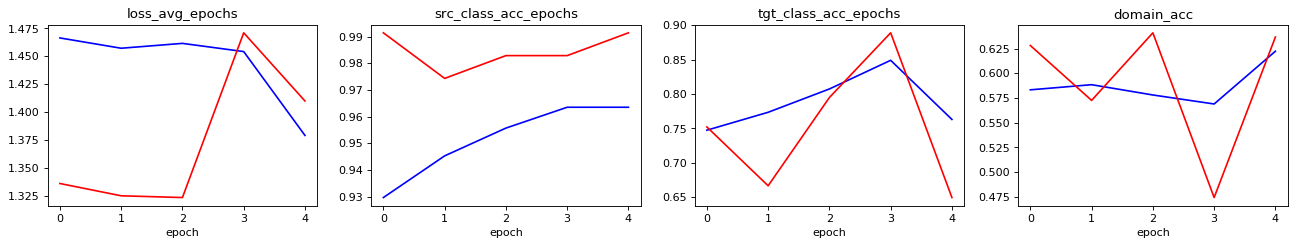

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (322, 3, 66)
val_data shape: (179, 3, 66)
Working on get_UPFall_loader...
train_data shape: (427, 3, 66)
val_data shape: (131, 3, 66)


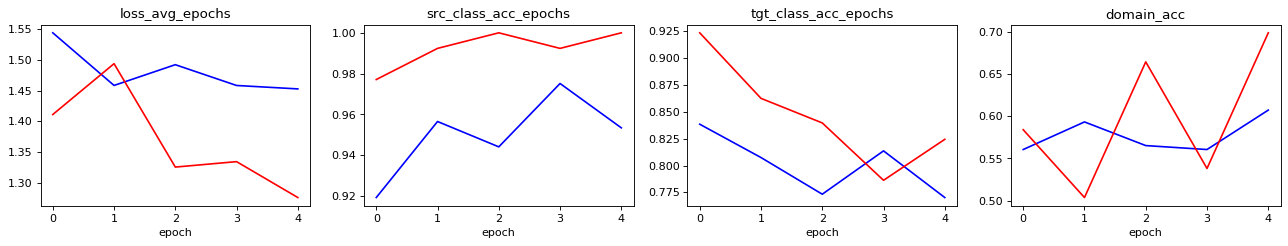

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (448, 3, 66)
val_data shape: (53, 3, 66)
Working on get_UPFall_loader...
train_data shape: (461, 3, 66)
val_data shape: (97, 3, 66)


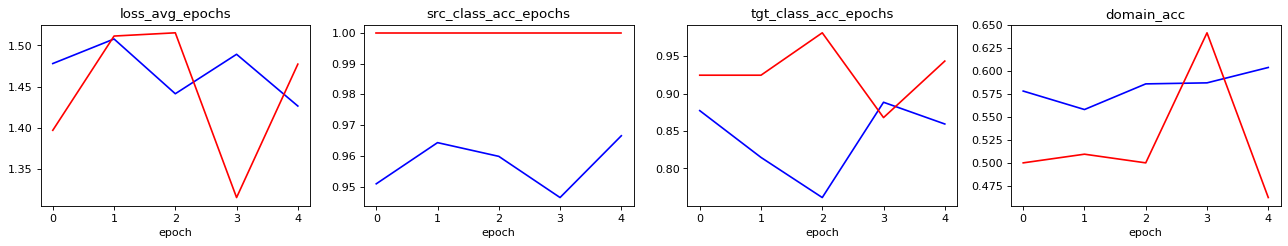

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (436, 3, 66)
val_data shape: (65, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (99, 3, 66)


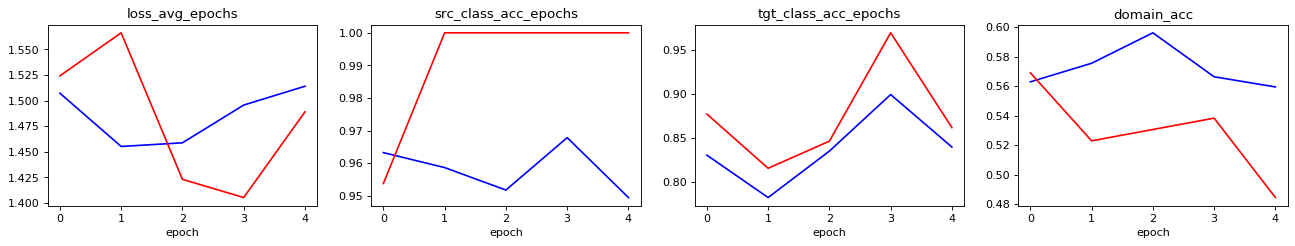

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (414, 3, 66)
val_data shape: (87, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (99, 3, 66)


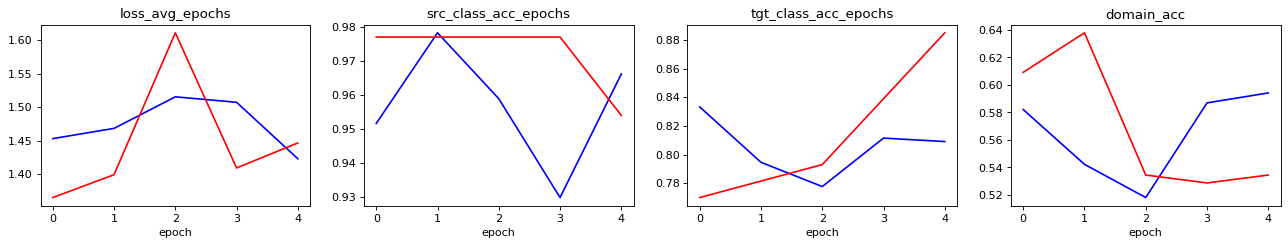

=================Exporting pytorch model=================
model saved successfully
===============Exporting model performance===============
show df_performance


,i_CV,train_src_class_loss,train_tgt_class_loss,train_src_domain_loss,train_tgt_domain_loss,train_src_class_acc,train_tgt_class_acc,train_domain_acc,val_src_class_loss,val_tgt_class_loss,val_src_domain_loss,val_tgt_domain_loss,val_src_class_acc,val_tgt_class_acc,val_domain_acc
0,0.000000,0.118575,0.776112,0.618573,0.642120,0.963542,0.763021,0.622396,0.032392,1.588923,0.480957,0.896732,0.991453,0.649573,0.636752
1,1.000000,0.153561,0.601877,0.642845,0.656486,0.953416,0.770186,0.607143,0.035791,0.816599,0.619423,0.620411,1.000000,0.824427,0.698473
2,2.000000,0.132696,0.325844,0.630150,0.663625,0.966518,0.859375,0.603795,0.028166,0.128140,0.792711,0.656455,1.000000,0.943396,0.462264
3,3.000000,0.135412,0.505277,0.686591,0.692064,0.949541,0.839450,0.559633,0.011840,0.373419,0.665470,0.811743,1.000000,0.861538,0.484615
4,4.000000,0.105212,0.573651,0.644692,0.672852,0.966184,0.809179,0.594203,0.098826,0.450735,0.694549,0.653015,0.954023,0.885057,0.534483
mean,1.500000,0.135061,0.552277,0.644540,0.663574,0.958254,0.808008,0.598242,0.027047,0.726770,0.639640,0.746335,0.997863,0.819734,0.570526
std,1.290994,0.014373,0.188010,0.029735,0.020994,0.008074,0.048585,0.026982,0.010607,0.641506,0.128694,0.130170,0.004274,0.123851,0.115264


val_src_class_acc: 0.9979±0.0043
val_tgt_class_acc: 0.8197±0.1239
val_domain_acc: 0.5705±0.1153
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 501, 'classes_n': 2, 'model_name': 'DannModel', 'src_dataset_name': 'UMAFall', 'tgt_dataset_name': 'UPFall', 'src_sensor_loc': 'waist', 'tgt_sensor_loc': 'belt', 'date': '2020/02/21 09:01:36', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': 2, 'label_dim': (1,)}
val_tgt_class_acc: 0.8197±0.1239
val_domain_acc: 0.5705±0.1153
time elapsed: 00:03:07


,UMAFall_waist_UPFall_belt
source,0.792±0.019
DANN,0.820±0.124
target,0.902±0.028
domain,0.571±0.115


In [25]:
# fine-tuning
df_performance_table = pd.DataFrame(0, index=['source', 'DANN', 'target', 'domain'], columns=[])
tasks_list = [('UMAFall_waist', 'UPFall_belt')]

# baseline
training_params = {
    'classes_n': 2,
    'CV_n': 5,
    'num_epochs': 5,
    'channel_n': 16,
    'batch_size': 1,
    'learning_rate': 0.001}

# optimize
# training_params = {
#     'classes_n': 2,
#     'CV_n': 5,
#     'num_epochs': 3,
#     'channel_n': 32,
#     'batch_size': 1,
#     'learning_rate': 0.01}

for task_item in tasks_list:
  (src_name, tgt_name) = task_item

  # inputdir = '/content/drive/My Drive/中研院/data_mic/stage1_preprocessed/'
  # outputdir = '/content/drive/My Drive/中研院/data_mic/stage2_modeloutput/{}_{}/'.format(src_name, tgt_name)
  inputdir = '/content/drive/My Drive/中研院/data_mic/stage1_preprocessed_18hz/'
  outputdir = '/content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz/{}_{}/'.format(src_name, tgt_name)
  if not os.path.exists(outputdir):
      os.makedirs(outputdir)
  print('outputdir for stage2 output:', outputdir)

  performance_table(src_name, tgt_name, training_params, df_performance_table, inputdir, outputdir)
  display(df_performance_table)

outputdir for stage2 output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz/UMAFall_waist_UPFall_belt/
========transferring knowledge from source(UMAFall_waist) to target(UPFall_belt)========
Working on get_UMAFall_loader...
train_data shape: (384, 3, 66)
val_data shape: (117, 3, 66)
Working on get_UPFall_loader...
train_data shape: (426, 3, 66)
val_data shape: (132, 3, 66)
Epoch 0
Train Loss: 0.385775, Train ACC: 0.929688, Val loss = 0.103632, Val ACC: 0.965812
Target Val loss = 4.879446, Val ACC: 0.689394
Epoch 1
Train Loss: 0.490347, Train ACC: 0.927083, Val loss = 0.173342, Val ACC: 0.974359
Target Val loss = 5.780769, Val ACC: 0.704545
Epoch 2
Train Loss: 0.479490, Train ACC: 0.945312, Val loss = 0.336747, Val ACC: 0.957265
Target Val loss = 5.467813, Val ACC: 0.750000
=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (322, 3, 66)
val_data shape: (179, 3, 66)
Working on get_UPFall_loa

,i_CV,train_loss,train_acc,val_loss,val_acc,tgt_val_loss,tgt_val_acc
0,0.000000,0.479490,0.945312,0.336747,0.957265,5.467813,0.750000
1,1.000000,0.283935,0.953416,0.000246,1.000000,3.694075,0.709924
2,2.000000,0.264980,0.950893,1.391835,0.830189,10.950438,0.721649
3,3.000000,0.386067,0.956422,0.311460,0.953846,1.563154,0.858586
4,4.000000,0.313496,0.949275,0.130695,0.988506,4.894984,0.707071
mean,1.500000,0.353618,0.951511,0.510072,0.935325,5.418870,0.760040
std,1.290994,0.099346,0.004710,0.607431,0.073169,4.018379,0.067817


src val loss: 0.5101±0.6074
src val acc: 0.9353±0.0732
tgt val loss: 5.4189±4.0184
tgt val acc: 0.7600±0.0678
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 501, 'classes_n': 2, 'model_name': 'BaselineModel', 'dataset_name': 'UMAFall', 'sensor_loc': 'waist', 'date': '2020/02/21 09:03:15', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': (1,), 'label_dim': 5}
Working on get_UMAFall_loader...
train_data shape: (426, 3, 66)
val_data shape: (132, 3, 66)
Working on get_UPFall_loader...
train_data shape: (384, 3, 66)
val_data shape: (117, 3, 66)
Epoch 0
Train Loss: 0.547707, Train ACC: 0.870892, Val loss = 0.220709, Val ACC: 0.909091
Target Val loss = 0.635066, Val ACC: 0.649573
Epoch 1
Train Loss: 0.625049, Train ACC: 0.845070, Val loss = 0.243331, Val ACC: 0.909091
Target Val loss = 0.767569, Val ACC: 0.666667
Epoch 2
Train Loss: 0.642199, Train ACC: 0.823944, Val loss = 0.262877, Val ACC: 0.909091
Target Val loss = 0.786317, Val ACC: 0.547009
===

,i_CV,train_loss,train_acc,val_loss,val_acc,tgt_val_loss,tgt_val_acc
0,0.000000,0.642199,0.823944,0.262877,0.909091,0.786317,0.547009
1,1.000000,0.657228,0.829040,0.373050,0.870229,0.785628,0.592179
2,2.000000,0.564135,0.861171,0.218004,0.927835,1.088936,0.584906
3,3.000000,0.610219,0.840959,0.372820,0.898990,1.963735,0.476923
4,4.000000,0.652671,0.840959,0.260910,0.898990,0.472635,0.770115
mean,1.500000,0.618445,0.838778,0.306688,0.901536,1.156154,0.550254
std,1.290994,0.041173,0.016544,0.078658,0.024051,0.557008,0.052746


src val loss: 0.3067±0.0787
src val acc: 0.9015±0.0241
tgt val loss: 1.1562±0.5570
tgt val acc: 0.5503±0.0527
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 558, 'classes_n': 2, 'model_name': 'BaselineModel', 'dataset_name': 'UPFall', 'sensor_loc': 'belt', 'date': '2020/02/21 09:03:49', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': (1,), 'label_dim': 5}
Working on get_UMAFall_loader...
train_data shape: (384, 3, 66)
val_data shape: (117, 3, 66)
Working on get_UPFall_loader...
train_data shape: (426, 3, 66)
val_data shape: (132, 3, 66)


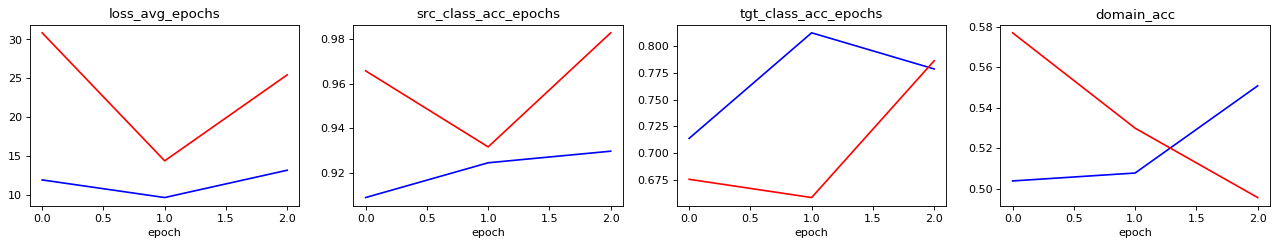

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (322, 3, 66)
val_data shape: (179, 3, 66)
Working on get_UPFall_loader...
train_data shape: (427, 3, 66)
val_data shape: (131, 3, 66)


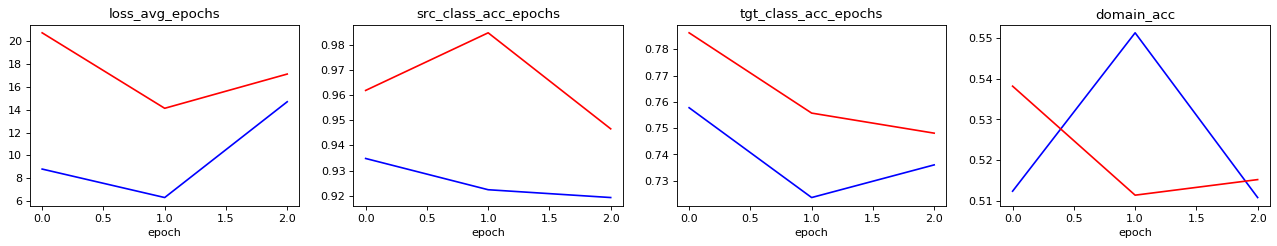

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (448, 3, 66)
val_data shape: (53, 3, 66)
Working on get_UPFall_loader...
train_data shape: (461, 3, 66)
val_data shape: (97, 3, 66)


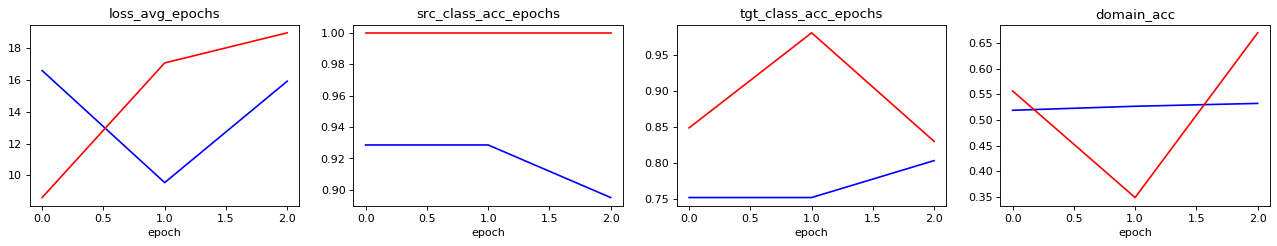

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (436, 3, 66)
val_data shape: (65, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (99, 3, 66)


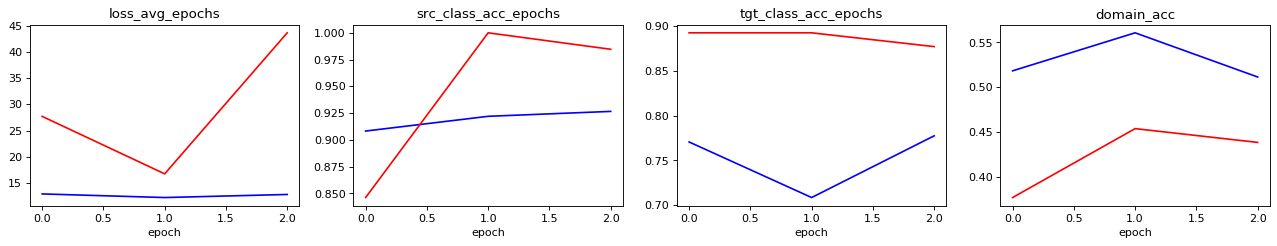

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (414, 3, 66)
val_data shape: (87, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (99, 3, 66)


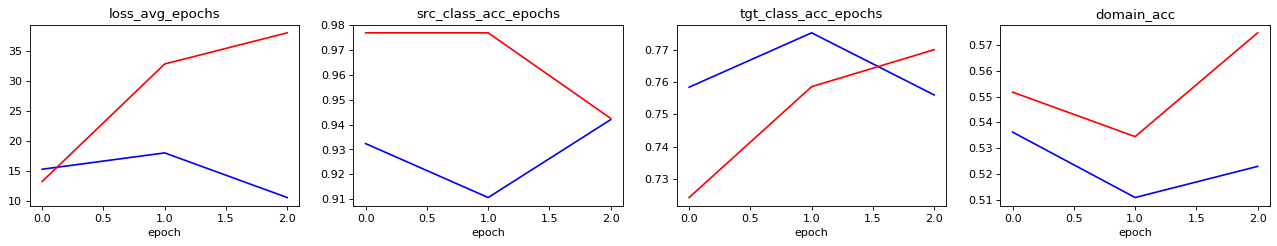

=================Exporting pytorch model=================
model saved successfully
===============Exporting model performance===============
show df_performance


,i_CV,train_src_class_loss,train_tgt_class_loss,train_src_domain_loss,train_tgt_domain_loss,train_src_class_acc,train_tgt_class_acc,train_domain_acc,val_src_class_loss,val_tgt_class_loss,val_src_domain_loss,val_tgt_domain_loss,val_src_class_acc,val_tgt_class_acc,val_domain_acc
0,0.000000,1.344672,12.738133,5.648129,6.215477,0.929688,0.778646,0.550781,0.058340,18.275605,0.249686,25.146823,0.982906,0.786325,0.495726
1,1.000000,0.971147,25.046644,6.326354,7.393393,0.919255,0.736025,0.510870,1.579965,38.820995,9.720923,5.816127,0.946565,0.748092,0.515267
2,2.000000,1.798190,5.154263,7.762923,6.346779,0.895089,0.803571,0.532366,0.000000,17.499893,0.273689,18.668776,1.000000,0.830189,0.669811
3,3.000000,0.960159,14.908898,5.214556,6.615741,0.926606,0.777523,0.511468,0.082454,20.835662,26.698185,16.881151,0.984615,0.876923,0.438462
4,4.000000,0.608590,18.853795,5.630768,4.387117,0.942029,0.756039,0.522947,1.891710,41.352138,17.323683,18.810965,0.942529,0.770115,0.574713
mean,1.500000,1.268542,14.461985,6.237991,6.642848,0.917659,0.773941,0.526371,0.430190,23.858039,9.235621,16.628219,0.978522,0.810382,0.529817
std,1.290994,0.395755,8.202441,1.114837,0.527369,0.015670,0.027991,0.019098,0.767298,10.076613,12.466487,8.035252,0.022649,0.055614,0.098857


val_src_class_acc: 0.9785±0.0226
val_tgt_class_acc: 0.8104±0.0556
val_domain_acc: 0.5298±0.0989
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 501, 'classes_n': 2, 'model_name': 'DannModel', 'src_dataset_name': 'UMAFall', 'tgt_dataset_name': 'UPFall', 'src_sensor_loc': 'waist', 'tgt_sensor_loc': 'belt', 'date': '2020/02/21 09:04:45', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': 2, 'label_dim': (1,)}
val_tgt_class_acc: 0.8104±0.0556
val_domain_acc: 0.5298±0.0989
time elapsed: 00:02:00


,UMAFall_waist_UPFall_belt
source,0.760±0.068
DANN,0.810±0.056
target,0.902±0.024
domain,0.530±0.099


outputdir for stage2 output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz/UMAFall_ankle_UPFall_ankle/
========transferring knowledge from source(UMAFall_ankle) to target(UPFall_ankle)========
Working on get_UMAFall_loader...
train_data shape: (396, 3, 66)
val_data shape: (134, 3, 66)
Working on get_UPFall_loader...
train_data shape: (426, 3, 66)
val_data shape: (132, 3, 66)
Epoch 0
Train Loss: 0.476257, Train ACC: 0.893939, Val loss = 0.313847, Val ACC: 0.955224
Target Val loss = 7.261129, Val ACC: 0.598485
Epoch 1
Train Loss: 0.786871, Train ACC: 0.858586, Val loss = 0.399654, Val ACC: 0.828358
Target Val loss = 4.731813, Val ACC: 0.613636
Epoch 2
Train Loss: 0.497136, Train ACC: 0.891414, Val loss = 0.142763, Val ACC: 0.955224
Target Val loss = 3.757246, Val ACC: 0.606061
=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (400, 3, 66)
val_data shape: (130, 3, 66)
Working on get_UPFall_l

,i_CV,train_loss,train_acc,val_loss,val_acc,tgt_val_loss,tgt_val_acc
0,0.000000,0.497136,0.891414,0.142763,0.955224,3.757246,0.606061
1,1.000000,0.655104,0.890000,0.235397,0.961538,10.652309,0.549618
2,2.000000,0.616205,0.875576,0.505384,0.958333,3.987830,0.742268
3,3.000000,0.538120,0.897321,1.279689,0.365854,4.736790,0.171717
4,4.000000,0.559811,0.868778,0.215638,0.954545,3.317392,0.686869
mean,1.500000,0.576641,0.888578,0.540808,0.810237,5.783544,0.517416
std,1.290994,0.071941,0.009230,0.516048,0.296267,3.272667,0.244241


src val loss: 0.5408±0.5160
src val acc: 0.8102±0.2963
tgt val loss: 5.7835±3.2727
tgt val acc: 0.5174±0.2442
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 530, 'classes_n': 2, 'model_name': 'BaselineModel', 'dataset_name': 'UMAFall', 'sensor_loc': 'ankle', 'date': '2020/02/21 09:05:45', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': (1,), 'label_dim': 5}
Working on get_UMAFall_loader...
train_data shape: (426, 3, 66)
val_data shape: (132, 3, 66)
Working on get_UPFall_loader...
train_data shape: (396, 3, 66)
val_data shape: (134, 3, 66)
Epoch 0
Train Loss: 0.622847, Train ACC: 0.840376, Val loss = 0.456758, Val ACC: 0.871212
Target Val loss = 1.503403, Val ACC: 0.671642
Epoch 1
Train Loss: 0.660201, Train ACC: 0.809859, Val loss = 0.236031, Val ACC: 0.909091
Target Val loss = 0.830260, Val ACC: 0.604478
Epoch 2
Train Loss: 0.657347, Train ACC: 0.838028, Val loss = 0.276912, Val ACC: 0.886364
Target Val loss = 0.733307, Val ACC: 0.634328
===

,i_CV,train_loss,train_acc,val_loss,val_acc,tgt_val_loss,tgt_val_acc
0,0.000000,0.657347,0.838028,0.276912,0.886364,0.733307,0.634328
1,1.000000,0.747797,0.824356,0.345015,0.900763,1.495363,0.553846
2,2.000000,0.523586,0.848156,0.306805,0.876289,0.782591,0.687500
3,3.000000,0.554624,0.834423,0.277362,0.878788,1.175665,0.402439
4,4.000000,0.699949,0.832244,0.317269,0.909091,0.867471,0.761364
mean,1.500000,0.620838,0.836241,0.301524,0.885551,1.046732,0.569528
std,1.290994,0.102134,0.009827,0.032192,0.011009,0.358655,0.124206


src val loss: 0.3015±0.0322
src val acc: 0.8856±0.0110
tgt val loss: 1.0467±0.3587
tgt val acc: 0.5695±0.1242
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 558, 'classes_n': 2, 'model_name': 'BaselineModel', 'dataset_name': 'UPFall', 'sensor_loc': 'ankle', 'date': '2020/02/21 09:06:18', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': (1,), 'label_dim': 5}
Working on get_UMAFall_loader...
train_data shape: (396, 3, 66)
val_data shape: (134, 3, 66)
Working on get_UPFall_loader...
train_data shape: (426, 3, 66)
val_data shape: (132, 3, 66)


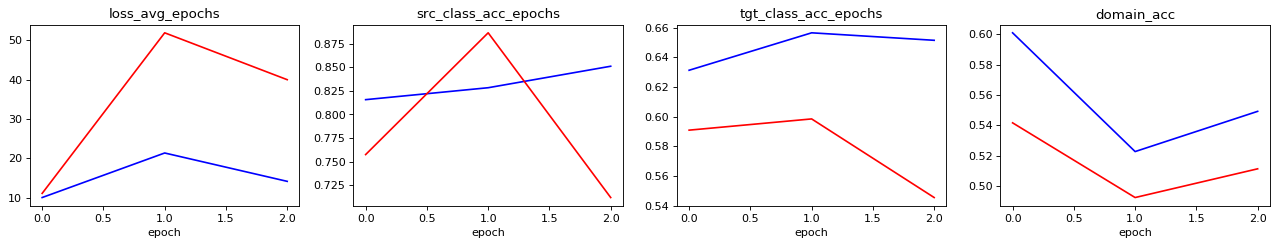

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (400, 3, 66)
val_data shape: (130, 3, 66)
Working on get_UPFall_loader...
train_data shape: (427, 3, 66)
val_data shape: (131, 3, 66)


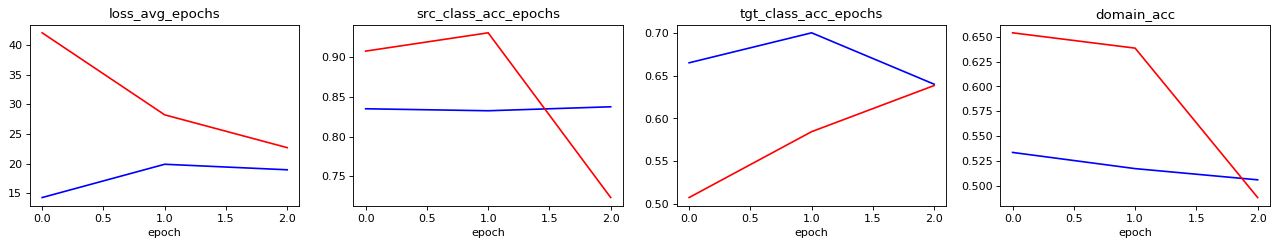

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (434, 3, 66)
val_data shape: (96, 3, 66)
Working on get_UPFall_loader...
train_data shape: (461, 3, 66)
val_data shape: (97, 3, 66)


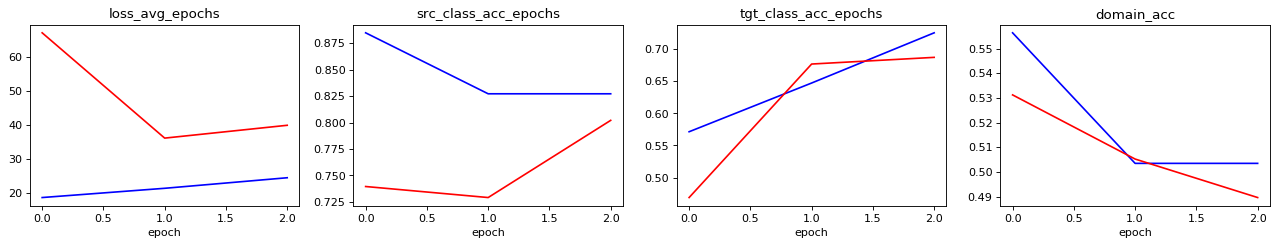

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (448, 3, 66)
val_data shape: (82, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (99, 3, 66)


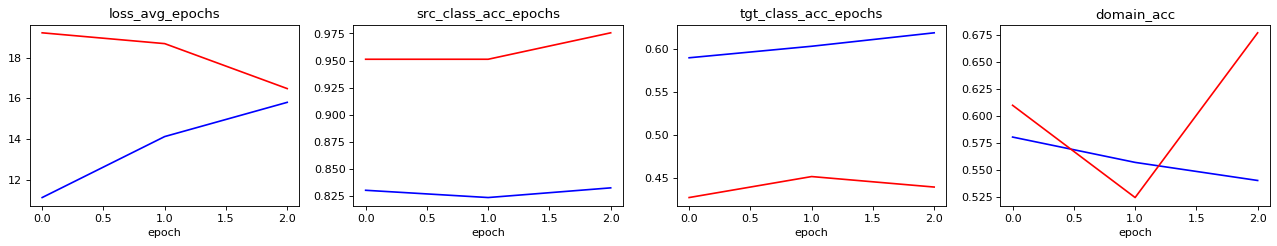

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (442, 3, 66)
val_data shape: (88, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (99, 3, 66)


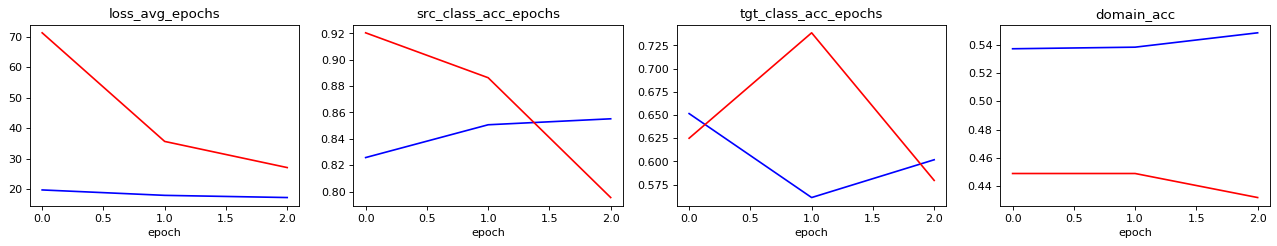

=================Exporting pytorch model=================
model saved successfully
===============Exporting model performance===============
show df_performance


,i_CV,train_src_class_loss,train_tgt_class_loss,train_src_domain_loss,train_tgt_domain_loss,train_src_class_acc,train_tgt_class_acc,train_domain_acc,val_src_class_loss,val_tgt_class_loss,val_src_domain_loss,val_tgt_domain_loss,val_src_class_acc,val_tgt_class_acc,val_domain_acc
0,0.000000,2.310420,13.763559,5.509290,6.344935,0.851010,0.651515,0.549242,12.164745,49.605611,0.000235,27.788318,0.712121,0.545455,0.511364
1,1.000000,3.530541,22.553486,7.637152,7.805488,0.837500,0.640000,0.506250,9.897730,39.298268,8.550921,4.251566,0.723077,0.638462,0.488462
2,2.000000,3.793074,8.633551,10.238598,10.421493,0.827189,0.725806,0.503456,10.422565,16.173997,16.719338,12.776420,0.802083,0.687500,0.489583
3,3.000000,3.873667,25.168455,6.221690,5.711661,0.832589,0.618304,0.540179,0.068521,91.986083,0.001726,16.411214,0.975610,0.439024,0.676829
4,4.000000,3.796913,18.800882,6.352793,7.133685,0.855204,0.601810,0.548643,5.970560,32.641440,9.541090,11.603975,0.795455,0.579545,0.431818
mean,1.500000,3.376925,17.529763,7.401683,7.570894,0.837072,0.658906,0.524782,8.138390,49.265990,6.318055,15.306879,0.803223,0.577610,0.541559
std,1.290994,0.725939,7.679286,2.087827,2.092898,0.010202,0.046677,0.023335,5.466475,31.725684,8.020458,9.757545,0.121712,0.109573,0.090794


val_src_class_acc: 0.8032±0.1217
val_tgt_class_acc: 0.5776±0.1096
val_domain_acc: 0.5416±0.0908
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 530, 'classes_n': 2, 'model_name': 'DannModel', 'src_dataset_name': 'UMAFall', 'tgt_dataset_name': 'UPFall', 'src_sensor_loc': 'ankle', 'tgt_sensor_loc': 'ankle', 'date': '2020/02/21 09:07:20', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': 2, 'label_dim': (1,)}
val_tgt_class_acc: 0.5776±0.1096
val_domain_acc: 0.5416±0.0908
time elapsed: 00:02:34


,UMAFall_waist_UPFall_belt,UMAFall_ankle_UPFall_ankle
source,0.760±0.068,0.517±0.244
DANN,0.810±0.056,0.578±0.110
target,0.902±0.024,0.886±0.011
domain,0.530±0.099,0.542±0.091


outputdir for stage2 output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz/UMAFall_wrist_UPFall_wrist/
========transferring knowledge from source(UMAFall_wrist) to target(UPFall_wrist)========
Working on get_UMAFall_loader...
train_data shape: (457, 3, 66)
val_data shape: (134, 3, 66)
Working on get_UPFall_loader...
train_data shape: (426, 3, 66)
val_data shape: (132, 3, 66)
Epoch 0
Train Loss: 0.435415, Train ACC: 0.919037, Val loss = 0.642590, Val ACC: 0.805970
Target Val loss = 1.348003, Val ACC: 0.613636
Epoch 1
Train Loss: 0.539099, Train ACC: 0.914661, Val loss = 0.140507, Val ACC: 0.940299
Target Val loss = 0.376531, Val ACC: 0.833333
Epoch 2
Train Loss: 0.545886, Train ACC: 0.901532, Val loss = 0.114664, Val ACC: 0.962687
Target Val loss = 0.302427, Val ACC: 0.901515
=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (400, 3, 66)
val_data shape: (191, 3, 66)
Working on get_UPFall_l

,i_CV,train_loss,train_acc,val_loss,val_acc,tgt_val_loss,tgt_val_acc
0,0.000000,0.545886,0.901532,0.114664,0.962687,0.302427,0.901515
1,1.000000,0.529336,0.915000,0.223955,0.968586,0.141674,0.954198
2,2.000000,0.517698,0.911111,0.077623,0.947917,0.388438,0.865979
3,3.000000,0.440625,0.907662,0.058213,0.987805,1.460217,0.747475
4,4.000000,0.456560,0.910537,0.543311,0.931818,0.176841,0.959596
mean,1.500000,0.508386,0.908826,0.118614,0.966749,0.573189,0.867292
std,1.290994,0.046631,0.005713,0.074029,0.016511,0.600130,0.087715


src val loss: 0.1186±0.0740
src val acc: 0.9667±0.0165
tgt val loss: 0.5732±0.6001
tgt val acc: 0.8673±0.0877
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 591, 'classes_n': 2, 'model_name': 'BaselineModel', 'dataset_name': 'UMAFall', 'sensor_loc': 'wrist', 'date': '2020/02/21 09:08:20', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': (1,), 'label_dim': 5}
Working on get_UMAFall_loader...
train_data shape: (426, 3, 66)
val_data shape: (132, 3, 66)
Working on get_UPFall_loader...
train_data shape: (457, 3, 66)
val_data shape: (134, 3, 66)
Epoch 0
Train Loss: 0.571177, Train ACC: 0.861502, Val loss = 0.303862, Val ACC: 0.878788
Target Val loss = 0.878364, Val ACC: 0.597015
Epoch 1
Train Loss: 0.838948, Train ACC: 0.840376, Val loss = 0.331933, Val ACC: 0.871212
Target Val loss = 0.674594, Val ACC: 0.544776
Epoch 2
Train Loss: 0.578523, Train ACC: 0.845070, Val loss = 0.284827, Val ACC: 0.893939
Target Val loss = 0.700191, Val ACC: 0.559701
===

,i_CV,train_loss,train_acc,val_loss,val_acc,tgt_val_loss,tgt_val_acc
0,0.000000,0.578523,0.845070,0.284827,0.893939,0.700191,0.559701
1,1.000000,0.590867,0.824356,0.269791,0.885496,0.546314,0.680628
2,2.000000,0.682613,0.822126,0.203854,0.927835,1.199613,0.562500
3,3.000000,0.566646,0.858388,0.515713,0.636364,1.062851,0.658537
4,4.000000,0.535792,0.836601,0.288873,0.898990,0.648829,0.647727
mean,1.500000,0.604663,0.837485,0.318546,0.835909,0.877242,0.615342
std,1.290994,0.052900,0.017347,0.136067,0.134282,0.305087,0.063288


src val loss: 0.3185±0.1361
src val acc: 0.8359±0.1343
tgt val loss: 0.8772±0.3051
tgt val acc: 0.6153±0.0633
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 558, 'classes_n': 2, 'model_name': 'BaselineModel', 'dataset_name': 'UPFall', 'sensor_loc': 'wrist', 'date': '2020/02/21 09:08:54', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': (1,), 'label_dim': 5}
Working on get_UMAFall_loader...
train_data shape: (457, 3, 66)
val_data shape: (134, 3, 66)
Working on get_UPFall_loader...
train_data shape: (426, 3, 66)
val_data shape: (132, 3, 66)


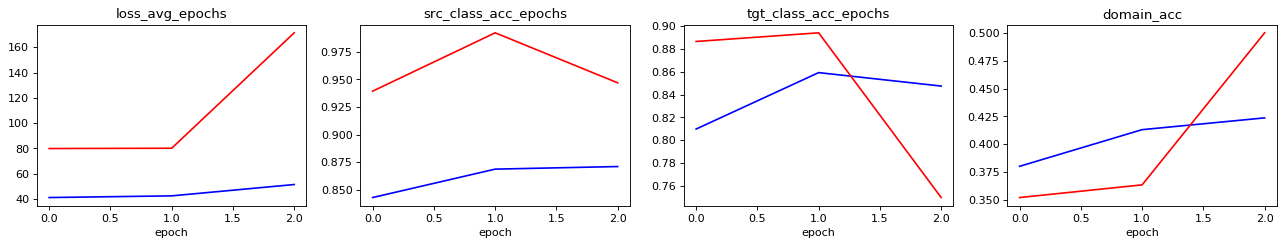

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (400, 3, 66)
val_data shape: (191, 3, 66)
Working on get_UPFall_loader...
train_data shape: (427, 3, 66)
val_data shape: (131, 3, 66)


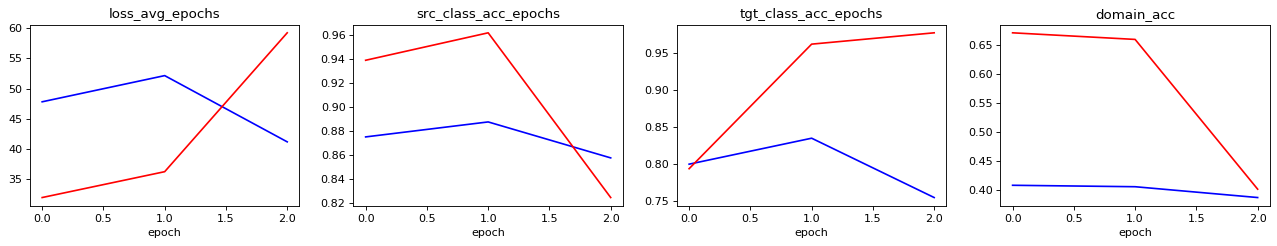

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (495, 3, 66)
val_data shape: (96, 3, 66)
Working on get_UPFall_loader...
train_data shape: (461, 3, 66)
val_data shape: (97, 3, 66)


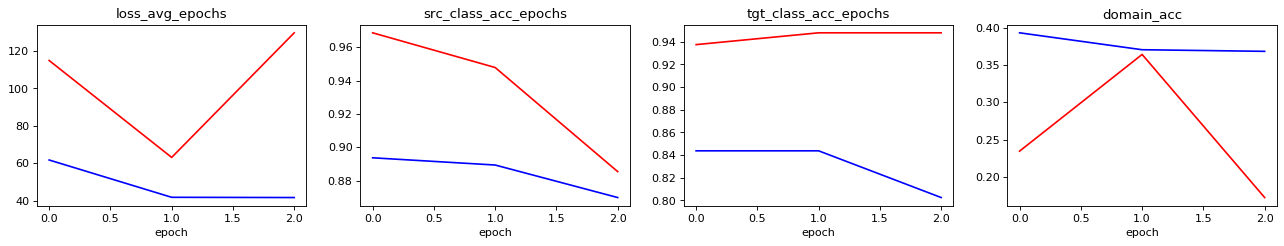

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (509, 3, 66)
val_data shape: (82, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (99, 3, 66)


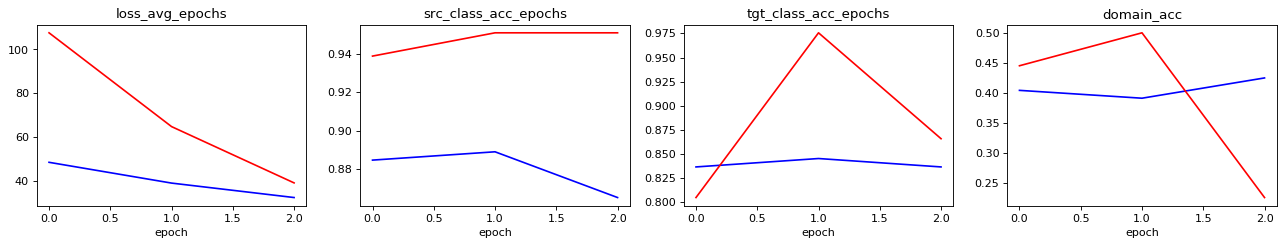

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (503, 3, 66)
val_data shape: (88, 3, 66)
Working on get_UPFall_loader...
train_data shape: (459, 3, 66)
val_data shape: (99, 3, 66)


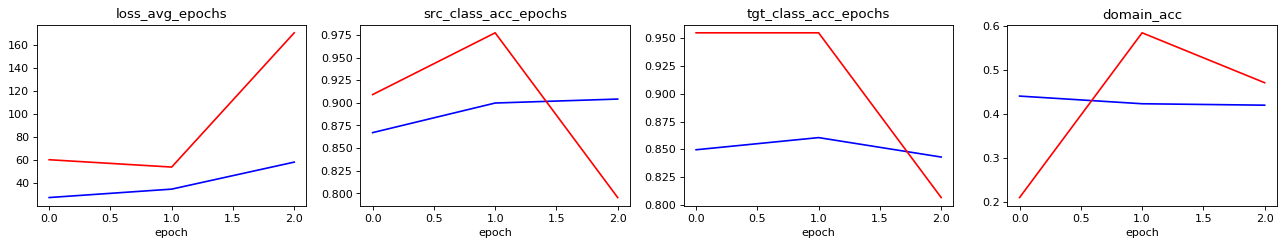

=================Exporting pytorch model=================
model saved successfully
===============Exporting model performance===============
show df_performance


,i_CV,train_src_class_loss,train_tgt_class_loss,train_src_domain_loss,train_tgt_domain_loss,train_src_class_acc,train_tgt_class_acc,train_domain_acc,val_src_class_loss,val_tgt_class_loss,val_src_domain_loss,val_tgt_domain_loss,val_src_class_acc,val_tgt_class_acc,val_domain_acc
0,0.000000,3.654007,7.929298,24.039880,23.799084,0.870892,0.847418,0.423709,2.787170,26.233377,0.000233,168.581204,0.946970,0.750000,0.500000
1,1.000000,3.086507,6.755008,20.792320,17.298929,0.857500,0.755000,0.386250,13.548552,0.875770,6.572351,39.112580,0.824427,0.977099,0.400763
2,2.000000,3.410714,5.456840,18.034759,20.252503,0.869848,0.802603,0.368764,3.009194,2.011877,38.276605,88.488138,0.885417,0.947917,0.171875
3,3.000000,3.098622,4.456747,14.516278,14.968177,0.864924,0.836601,0.424837,1.445689,7.039486,10.523105,27.276063,0.951220,0.865854,0.225610
4,4.000000,3.140746,7.042652,29.890517,25.355482,0.904139,0.843137,0.420479,33.849814,30.625814,0.909162,135.603411,0.795455,0.806818,0.471591
mean,1.500000,3.312463,6.149474,19.345809,19.079673,0.865791,0.810406,0.400890,5.197651,9.040128,13.843074,80.864496,0.902008,0.885217,0.324562
std,1.290994,0.272696,1.514322,4.048453,3.817670,0.006109,0.041580,0.027932,5.609947,11.770917,16.857316,64.206135,0.059826,0.101706,0.152414


val_src_class_acc: 0.9020±0.0598
val_tgt_class_acc: 0.8852±0.1017
val_domain_acc: 0.3246±0.1524
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 591, 'classes_n': 2, 'model_name': 'DannModel', 'src_dataset_name': 'UMAFall', 'tgt_dataset_name': 'UPFall', 'src_sensor_loc': 'wrist', 'tgt_sensor_loc': 'wrist', 'date': '2020/02/21 09:09:58', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': 2, 'label_dim': (1,)}
val_tgt_class_acc: 0.8852±0.1017
val_domain_acc: 0.3246±0.1524
time elapsed: 00:02:37


,UMAFall_waist_UPFall_belt,UMAFall_ankle_UPFall_ankle,UMAFall_wrist_UPFall_wrist
source,0.760±0.068,0.517±0.244,0.867±0.088
DANN,0.810±0.056,0.578±0.110,0.885±0.102
target,0.902±0.024,0.886±0.011,0.836±0.134
domain,0.530±0.099,0.542±0.091,0.325±0.152


outputdir for stage2 output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz/UMAFall_leg_UPFall_rightpocket/
========transferring knowledge from source(UMAFall_leg) to target(UPFall_rightpocket)========
Working on get_UMAFall_loader...
train_data shape: (457, 3, 66)
val_data shape: (134, 3, 66)
Working on get_UPFall_loader...
train_data shape: (395, 3, 66)
val_data shape: (97, 3, 66)
Epoch 0
Train Loss: 0.626916, Train ACC: 0.903720, Val loss = 0.038586, Val ACC: 0.985075
Target Val loss = 0.382710, Val ACC: 0.886598
Epoch 1
Train Loss: 0.405385, Train ACC: 0.901532, Val loss = 0.532927, Val ACC: 0.895522
Target Val loss = 0.091475, Val ACC: 0.969072
Epoch 2
Train Loss: 0.502543, Train ACC: 0.894967, Val loss = 0.012566, Val ACC: 0.992537
Target Val loss = 0.392136, Val ACC: 0.907216
=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (400, 3, 66)
val_data shape: (191, 3, 66)
Working on get_U

,i_CV,train_loss,train_acc,val_loss,val_acc,tgt_val_loss,tgt_val_acc
0,0.000000,0.502543,0.894967,0.012566,0.992537,0.392136,0.907216
1,1.000000,0.424230,0.917500,0.372941,0.931937,1.899742,0.787879
2,2.000000,0.386137,0.915152,0.314544,0.906250,2.613055,0.676768
3,3.000000,0.590443,0.897839,0.061731,1.000000,0.177538,0.949495
4,4.000000,0.478088,0.902584,0.016165,1.000000,0.092752,0.959184
mean,1.500000,0.475838,0.906364,0.190446,0.957681,1.270618,0.830339
std,1.290994,0.090475,0.011602,0.179735,0.045876,1.178203,0.123147


src val loss: 0.1904±0.1797
src val acc: 0.9577±0.0459
tgt val loss: 1.2706±1.1782
tgt val acc: 0.8303±0.1231
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 591, 'classes_n': 2, 'model_name': 'BaselineModel', 'dataset_name': 'UMAFall', 'sensor_loc': 'leg', 'date': '2020/02/21 09:10:53', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': (1,), 'label_dim': 5}
Working on get_UMAFall_loader...
train_data shape: (395, 3, 66)
val_data shape: (97, 3, 66)
Working on get_UPFall_loader...
train_data shape: (457, 3, 66)
val_data shape: (134, 3, 66)
Epoch 0
Train Loss: 0.632042, Train ACC: 0.827848, Val loss = 0.251161, Val ACC: 0.886598
Target Val loss = 0.791498, Val ACC: 0.656716
Epoch 1
Train Loss: 0.558884, Train ACC: 0.853165, Val loss = 0.244573, Val ACC: 0.927835
Target Val loss = 1.771544, Val ACC: 0.544776
Epoch 2
Train Loss: 0.727590, Train ACC: 0.832911, Val loss = 0.268556, Val ACC: 0.824742
Target Val loss = 0.732932, Val ACC: 0.626866
======

,i_CV,train_loss,train_acc,val_loss,val_acc,tgt_val_loss,tgt_val_acc
0,0.000000,0.727590,0.832911,0.268556,0.824742,0.732932,0.626866
1,1.000000,0.604949,0.844784,0.242359,0.888889,0.933323,0.643979
2,2.000000,0.723136,0.832061,0.257967,0.898990,0.933794,0.625000
3,3.000000,0.851026,0.826972,1.124176,0.424242,1.561610,0.548780
4,4.000000,0.569777,0.850254,0.301030,0.877551,0.981388,0.579545
mean,1.500000,0.726675,0.834182,0.473264,0.759216,1.040414,0.611156
std,1.290994,0.100488,0.007539,0.434074,0.225723,0.360105,0.042452


src val loss: 0.4733±0.4341
src val acc: 0.7592±0.2257
tgt val loss: 1.0404±0.3601
tgt val acc: 0.6112±0.0425
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 492, 'classes_n': 2, 'model_name': 'BaselineModel', 'dataset_name': 'UPFall', 'sensor_loc': 'rightpocket', 'date': '2020/02/21 09:11:24', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': (1,), 'label_dim': 5}
Working on get_UMAFall_loader...
train_data shape: (457, 3, 66)
val_data shape: (134, 3, 66)
Working on get_UPFall_loader...
train_data shape: (395, 3, 66)
val_data shape: (97, 3, 66)


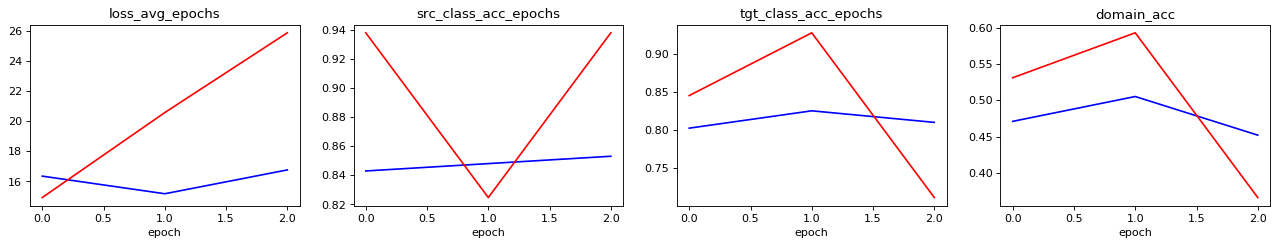

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (400, 3, 66)
val_data shape: (191, 3, 66)
Working on get_UPFall_loader...
train_data shape: (393, 3, 66)
val_data shape: (99, 3, 66)


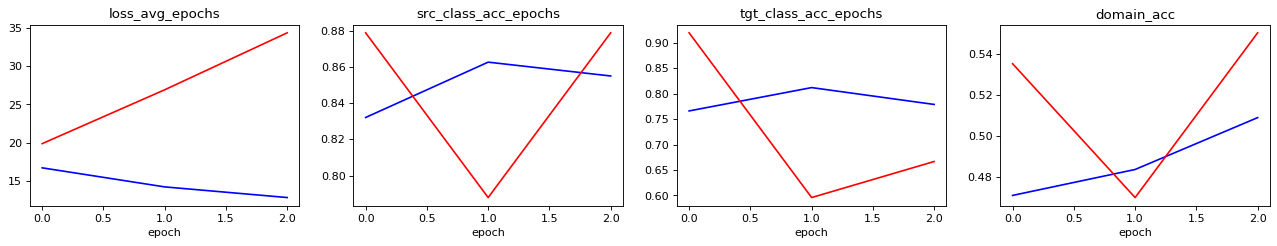

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (495, 3, 66)
val_data shape: (96, 3, 66)
Working on get_UPFall_loader...
train_data shape: (393, 3, 66)
val_data shape: (99, 3, 66)


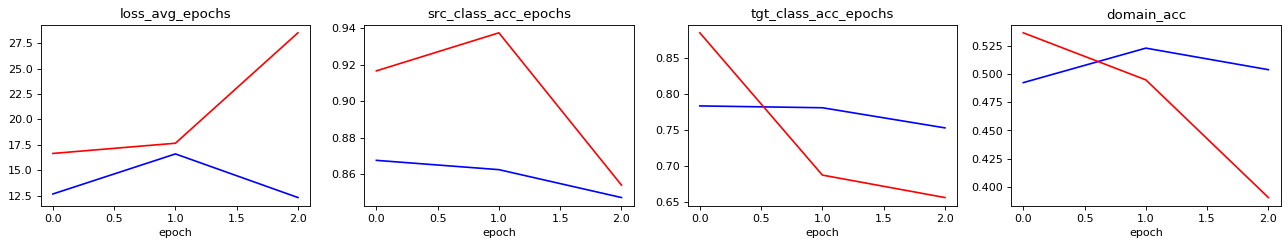

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (509, 3, 66)
val_data shape: (82, 3, 66)
Working on get_UPFall_loader...
train_data shape: (393, 3, 66)
val_data shape: (99, 3, 66)


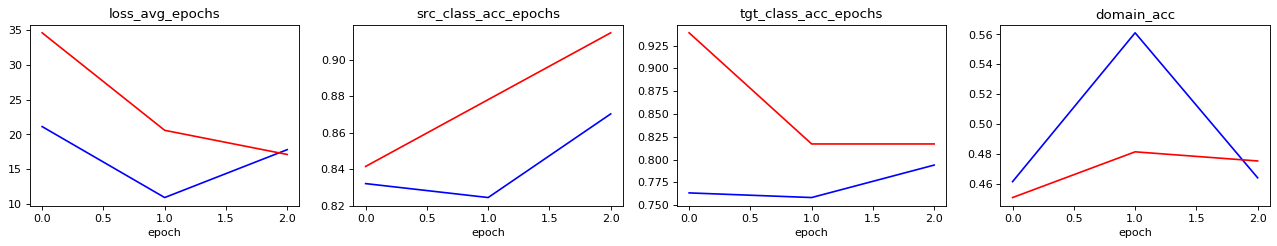

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (503, 3, 66)
val_data shape: (88, 3, 66)
Working on get_UPFall_loader...
train_data shape: (394, 3, 66)
val_data shape: (98, 3, 66)


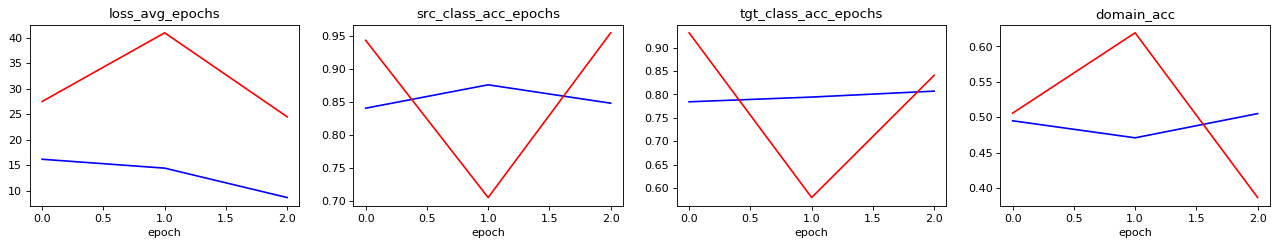

=================Exporting pytorch model=================
model saved successfully
===============Exporting model performance===============
show df_performance


,i_CV,train_src_class_loss,train_tgt_class_loss,train_src_domain_loss,train_tgt_domain_loss,train_src_class_acc,train_tgt_class_acc,train_domain_acc,val_src_class_loss,val_tgt_class_loss,val_src_domain_loss,val_tgt_domain_loss,val_src_class_acc,val_tgt_class_acc,val_domain_acc
0,0.000000,2.859114,4.009250,6.698576,7.210302,0.853165,0.810127,0.451899,1.546307,4.302685,18.939286,5.391599,0.938144,0.711340,0.365979
1,1.000000,2.493564,6.018409,5.142349,5.214402,0.854962,0.778626,0.508906,1.915315,11.005894,0.951315,31.479973,0.878788,0.666667,0.550505
2,2.000000,2.500603,6.545555,4.126100,5.679119,0.847328,0.753181,0.503817,7.421174,21.101204,14.655422,6.446396,0.854167,0.656250,0.390625
3,3.000000,1.957069,4.583092,7.127369,8.725590,0.870229,0.793893,0.464377,2.002063,3.739664,3.138217,11.978264,0.914634,0.817073,0.475610
4,4.000000,1.831043,2.515309,3.537692,3.333581,0.847716,0.807107,0.505076,0.545998,4.696846,22.134405,1.841154,0.954545,0.840909,0.386364
mean,1.500000,2.452587,5.289077,5.773599,6.707353,0.856421,0.783957,0.482249,3.221215,10.037362,9.421060,13.824058,0.896433,0.712833,0.445680
std,1.290994,0.371836,1.189823,1.390564,1.592943,0.009765,0.024216,0.028380,2.806937,8.080722,8.740821,12.119881,0.037278,0.073487,0.084197


val_src_class_acc: 0.8964±0.0373
val_tgt_class_acc: 0.7128±0.0735
val_domain_acc: 0.4457±0.0842
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 591, 'classes_n': 2, 'model_name': 'DannModel', 'src_dataset_name': 'UMAFall', 'tgt_dataset_name': 'UPFall', 'src_sensor_loc': 'leg', 'tgt_sensor_loc': 'rightpocket', 'date': '2020/02/21 09:12:23', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': 2, 'label_dim': (1,)}
val_tgt_class_acc: 0.7128±0.0735
val_domain_acc: 0.4457±0.0842
time elapsed: 00:02:25


,UMAFall_waist_UPFall_belt,UMAFall_ankle_UPFall_ankle,UMAFall_wrist_UPFall_wrist,UMAFall_leg_UPFall_rightpocket
source,0.760±0.068,0.517±0.244,0.867±0.088,0.830±0.123
DANN,0.810±0.056,0.578±0.110,0.885±0.102,0.713±0.073
target,0.902±0.024,0.886±0.011,0.836±0.134,0.759±0.226
domain,0.530±0.099,0.542±0.091,0.325±0.152,0.446±0.084


outputdir for stage2 output: /content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz/UMAFall_all_UPFall_all/
========transferring knowledge from source(UMAFall_all) to target(UPFall_all)========
Working on get_UMAFall_loader...
train_data shape: (2151, 3, 66)
val_data shape: (652, 3, 66)
Working on get_UPFall_loader...
train_data shape: (2099, 3, 66)
val_data shape: (625, 3, 66)
Epoch 0
Train Loss: 0.252720, Train ACC: 0.934914, Val loss = 0.081498, Val ACC: 0.967791
Target Val loss = 0.278746, Val ACC: 0.928000
Epoch 1
Train Loss: 0.249314, Train ACC: 0.933984, Val loss = 0.075889, Val ACC: 0.969325
Target Val loss = 0.532319, Val ACC: 0.884800
Epoch 2
Train Loss: 0.255382, Train ACC: 0.928405, Val loss = 0.027278, Val ACC: 0.984663
Target Val loss = 0.232491, Val ACC: 0.932800
=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (1921, 3, 66)
val_data shape: (882, 3, 66)
Working on get_UPFall_loader

,i_CV,train_loss,train_acc,val_loss,val_acc,tgt_val_loss,tgt_val_acc
0,0.000000,0.255382,0.928405,0.027278,0.984663,0.232491,0.932800
1,1.000000,0.270364,0.940135,0.315548,0.897959,0.127444,0.959872
2,2.000000,0.220659,0.942942,0.308665,0.917620,0.343526,0.895277
3,3.000000,0.246967,0.939004,0.035986,0.984733,0.427277,0.894949
4,4.000000,0.221514,0.942047,0.235408,0.922551,0.286862,0.908907
mean,1.500000,0.248343,0.937622,0.171870,0.946244,0.282684,0.920725
std,1.290994,0.020839,0.006363,0.161995,0.045123,0.130675,0.031571


src val loss: 0.1719±0.1620
src val acc: 0.9462±0.0451
tgt val loss: 0.2827±0.1307
tgt val acc: 0.9207±0.0316
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 2803, 'classes_n': 2, 'model_name': 'BaselineModel', 'dataset_name': 'UMAFall', 'sensor_loc': 'all', 'date': '2020/02/21 09:15:42', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': (1,), 'label_dim': 5}
Working on get_UMAFall_loader...
train_data shape: (2099, 3, 66)
val_data shape: (625, 3, 66)
Working on get_UPFall_loader...
train_data shape: (2151, 3, 66)
val_data shape: (652, 3, 66)
Epoch 0
Train Loss: 0.367316, Train ACC: 0.873273, Val loss = 0.230925, Val ACC: 0.907200
Target Val loss = 1.200014, Val ACC: 0.579755
Epoch 1
Train Loss: 0.347099, Train ACC: 0.877084, Val loss = 0.249367, Val ACC: 0.908800
Target Val loss = 1.206241, Val ACC: 0.588957
Epoch 2
Train Loss: 0.355135, Train ACC: 0.876131, Val loss = 0.214759, Val ACC: 0.908800
Target Val loss = 1.164146, Val ACC: 0.570552
==

,i_CV,train_loss,train_acc,val_loss,val_acc,tgt_val_loss,tgt_val_acc
0,0.000000,0.355135,0.876131,0.214759,0.908800,1.164146,0.570552
1,1.000000,0.365338,0.878153,0.206296,0.902087,1.504333,0.616780
2,2.000000,0.378781,0.871703,0.232811,0.917864,1.895956,0.576659
3,3.000000,0.368676,0.873934,0.514884,0.832323,1.365777,0.521628
4,4.000000,0.353862,0.876682,0.273843,0.902834,0.621220,0.685649
mean,1.500000,0.366982,0.874981,0.292188,0.890269,1.482553,0.571405
std,1.290994,0.009749,0.002782,0.148876,0.039167,0.308975,0.039008


src val loss: 0.2922±0.1489
src val acc: 0.8903±0.0392
tgt val loss: 1.4826±0.3090
tgt val acc: 0.5714±0.0390
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 2724, 'classes_n': 2, 'model_name': 'BaselineModel', 'dataset_name': 'UPFall', 'sensor_loc': 'all', 'date': '2020/02/21 09:18:24', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': (1,), 'label_dim': 5}
Working on get_UMAFall_loader...
train_data shape: (2151, 3, 66)
val_data shape: (652, 3, 66)
Working on get_UPFall_loader...
train_data shape: (2099, 3, 66)
val_data shape: (625, 3, 66)


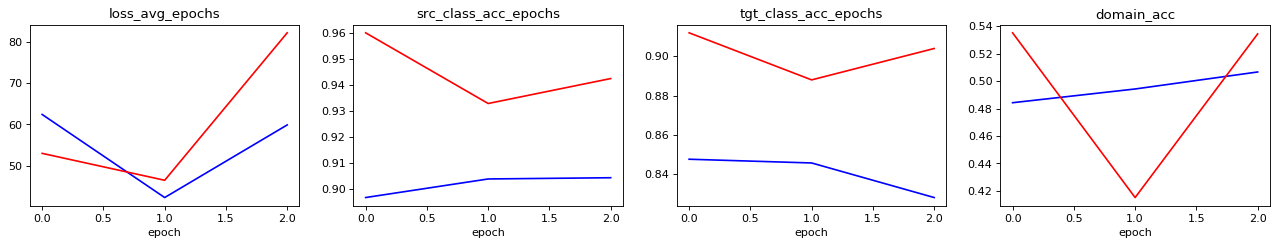

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (1921, 3, 66)
val_data shape: (882, 3, 66)
Working on get_UPFall_loader...
train_data shape: (2101, 3, 66)
val_data shape: (623, 3, 66)


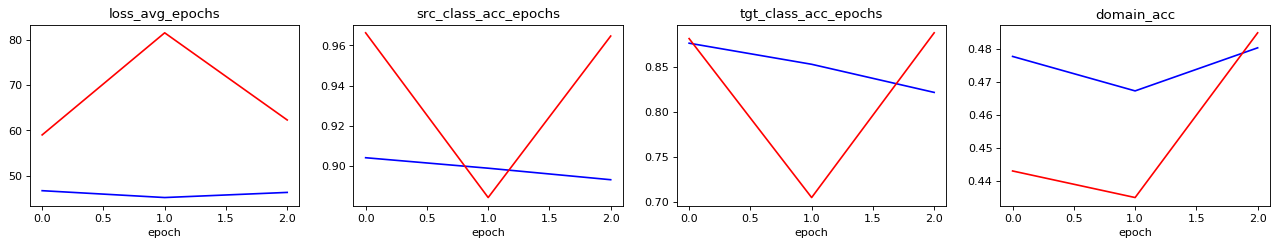

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (2366, 3, 66)
val_data shape: (437, 3, 66)
Working on get_UPFall_loader...
train_data shape: (2237, 3, 66)
val_data shape: (487, 3, 66)


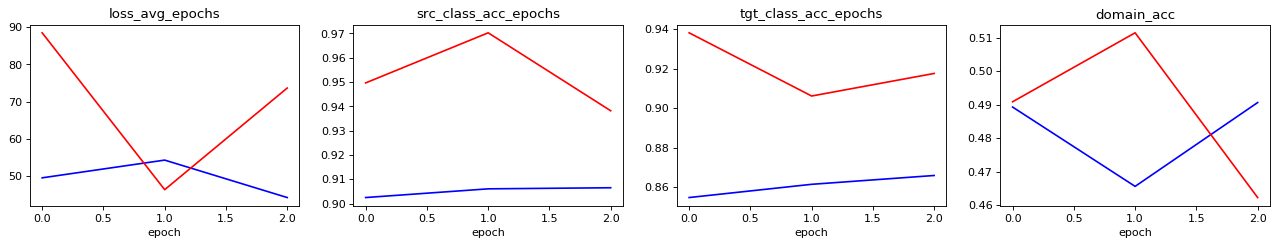

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (2410, 3, 66)
val_data shape: (393, 3, 66)
Working on get_UPFall_loader...
train_data shape: (2229, 3, 66)
val_data shape: (495, 3, 66)


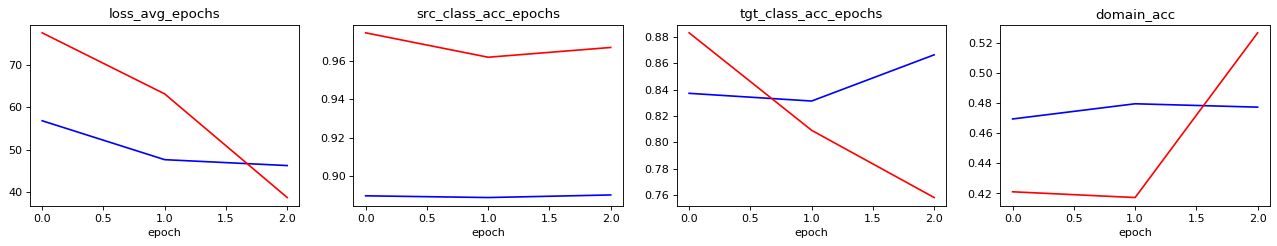

=================Exporting pytorch model=================
model saved successfully
Working on get_UMAFall_loader...
train_data shape: (2364, 3, 66)
val_data shape: (439, 3, 66)
Working on get_UPFall_loader...
train_data shape: (2230, 3, 66)
val_data shape: (494, 3, 66)


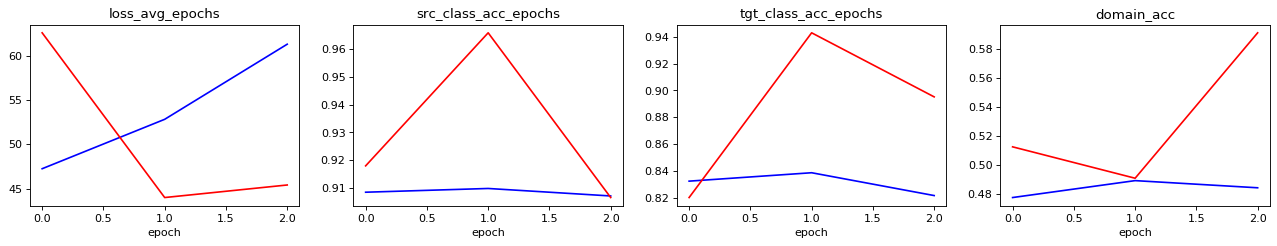

=================Exporting pytorch model=================
model saved successfully
===============Exporting model performance===============
show df_performance


,i_CV,train_src_class_loss,train_tgt_class_loss,train_src_domain_loss,train_tgt_domain_loss,train_src_class_acc,train_tgt_class_acc,train_domain_acc,val_src_class_loss,val_tgt_class_loss,val_src_domain_loss,val_tgt_domain_loss,val_src_class_acc,val_tgt_class_acc,val_domain_acc
0,0.000000,8.798857,17.007796,24.181403,26.905514,0.904240,0.828013,0.506670,5.467025,18.417554,6.060233,70.784813,0.942400,0.904000,0.534400
1,1.000000,7.068693,14.185651,18.460944,20.752657,0.893285,0.821447,0.480219,4.870537,16.594518,51.180353,6.263774,0.964687,0.887640,0.484751
2,2.000000,5.755292,10.339404,17.839160,20.551227,0.906571,0.865892,0.490612,7.141419,9.276299,50.620406,15.876951,0.938215,0.917620,0.462243
3,3.000000,6.796508,9.138778,18.996329,20.478682,0.890085,0.866308,0.477344,4.913607,48.262704,5.855581,27.954370,0.966921,0.758270,0.526718
4,4.000000,6.975014,22.092023,25.104427,29.222712,0.907175,0.821525,0.484305,15.684348,13.383469,9.700816,20.035116,0.906606,0.895216,0.591116
mean,1.500000,7.104838,12.667907,19.869459,22.172020,0.898545,0.845415,0.488711,5.598147,23.137769,28.429143,30.219977,0.953056,0.866883,0.502028
std,1.290994,1.263243,3.606238,2.913260,3.157791,0.008085,0.024035,0.013260,1.064095,17.209467,25.948690,28.462027,0.014847,0.073439,0.034346


val_src_class_acc: 0.9531±0.0148
val_tgt_class_acc: 0.8669±0.0734
val_domain_acc: 0.5020±0.0343
==============Exporting notebook parameters==============
{'CV_n': 5, 'samples_n': 2803, 'classes_n': 2, 'model_name': 'DannModel', 'src_dataset_name': 'UMAFall', 'tgt_dataset_name': 'UPFall', 'src_sensor_loc': 'all', 'tgt_sensor_loc': 'all', 'date': '2020/02/21 09:23:20', 'batch_size': 1, 'input_dim': (1, 3, 66), 'output_dim': 2, 'label_dim': (1,)}
val_tgt_class_acc: 0.8669±0.0734
val_domain_acc: 0.5020±0.0343
time elapsed: 00:10:57


,UMAFall_waist_UPFall_belt,UMAFall_ankle_UPFall_ankle,UMAFall_wrist_UPFall_wrist,UMAFall_leg_UPFall_rightpocket,UMAFall_all_UPFall_all
source,0.760±0.068,0.517±0.244,0.867±0.088,0.830±0.123,0.921±0.032
DANN,0.810±0.056,0.578±0.110,0.885±0.102,0.713±0.073,0.867±0.073
target,0.902±0.024,0.886±0.011,0.836±0.134,0.759±0.226,0.890±0.039
domain,0.530±0.099,0.542±0.091,0.325±0.152,0.446±0.084,0.502±0.034


In [26]:
df_performance_table = pd.DataFrame(0, index=['source', 'DANN', 'target', 'domain'], columns=[])
# tasks_list = [('UMAFall_waist', 'UPFall_belt'), ('UMAFall_ankle', 'UPFall_ankle'), ('UMAFall_wrist', 'UPFall_wrist'), ('UMAFall_leg', 'UPFall_rightpocket')]
# tasks_list = [('UMAFall_all', 'UPFall_all')]
tasks_list = [('UMAFall_waist', 'UPFall_belt'), ('UMAFall_ankle', 'UPFall_ankle'), ('UMAFall_wrist', 'UPFall_wrist'), ('UMAFall_leg', 'UPFall_rightpocket'), ('UMAFall_all', 'UPFall_all')]

optimal_training_params = {
    'classes_n': 2,
    'CV_n': 5,
    'num_epochs': 3,
    'channel_n': 32,
    'batch_size': 1,
    'learning_rate': 0.01}

for task_item in tasks_list:
  (src_name, tgt_name) = task_item

  # inputdir = '/content/drive/My Drive/中研院/data_mic/stage1_preprocessed/'
  # outputdir = '/content/drive/My Drive/中研院/data_mic/stage2_modeloutput/{}_{}/'.format(src_name, tgt_name)
  inputdir = '/content/drive/My Drive/中研院/data_mic/stage1_preprocessed_18hz/'
  outputdir = '/content/drive/My Drive/中研院/data_mic/stage2_modeloutput_18hz/{}_{}/'.format(src_name, tgt_name)
  if not os.path.exists(outputdir):
      os.makedirs(outputdir)
  print('outputdir for stage2 output:', outputdir)

  performance_table(src_name, tgt_name, optimal_training_params, df_performance_table, inputdir, outputdir)
  display(df_performance_table)

In [27]:
display(df_performance_table)
df_performance_table.to_csv('df_performance_table.csv', encoding='utf-8', index=False)

,UMAFall_waist_UPFall_belt,UMAFall_ankle_UPFall_ankle,UMAFall_wrist_UPFall_wrist,UMAFall_leg_UPFall_rightpocket,UMAFall_all_UPFall_all
source,0.760±0.068,0.517±0.244,0.867±0.088,0.830±0.123,0.921±0.032
DANN,0.810±0.056,0.578±0.110,0.885±0.102,0.713±0.073,0.867±0.073
target,0.902±0.024,0.886±0.011,0.836±0.134,0.759±0.226,0.890±0.039
domain,0.530±0.099,0.542±0.091,0.325±0.152,0.446±0.084,0.502±0.034


In [0]:
# def show_results
# (val_tgt_class_acc_mean, val_tgt_class_acc_std), (val_domain_acc_mean, val_domain_acc_std) = dann_outputs
# (_,_), (source_tgt_acc_mean, source_tgt_acc_std) = source_outputs
# (target_tgt_acc_mean, target_tgt_acc_std), (_,_) = target_outputs

# print('--------------------------------------------------------------------------------------')
# print('\tResults of DA from source ({}) to target ({})'.format(src_name, tgt_name))
# print('--------------------------------------------------------------------------------------\n')



# print('train on source: {:.4f}±{:.4f}'.format(source_tgt_acc_mean, source_tgt_acc_std))
# print('DANN: {:.4f}±{:.4f}'.format(val_tgt_class_acc_mean, val_tgt_class_acc_std))
# print('train on target: {:.4f}±{:.4f}'.format(target_tgt_acc_mean, target_tgt_acc_std))
# print('DANN domain classification: {:.4f}±{:.4f}'.format(val_domain_acc_mean, val_domain_acc_std))

# print('\n--------------------------------------------------------------------------------------')
# print('\t\t\t\tEnd of results')
# print('--------------------------------------------------------------------------------------\n')

## Feature space clustering